# A Tutorial on Tailored Simulation-Based Sample Size Planning for

Experimental Designs with Generalized Linear Mixed Models

Florian Pargent [](https://orcid.org/0000-0002-2388-553X) (LMU Munich)  
Timo K. Koch [](https://orcid.org/0000-0001-6728-2063) (LMU Munich, University of St. Gallen)  
Anne-Kathrin Kleine [](https://orcid.org/0000-0003-1919-2834) (LMU Munich)  
Eva Lermer [](https://orcid.org/0000-0002-6600-9580) (LMU Munich, Technical University of Applied Sciences Augsburg)  
Susanne Gaube [](https://orcid.org/0000-0002-1633-4772) (LMU Munich, University College London)  
2024-06-12

When planning experimental research, determining an appropriate sample size and using suitable statistical models are crucial for robust and informative results. The recent replication crisis underlines the need for more rigorous statistical methodology and adequately powered designs. Generalized linear mixed models (GLMMs) offer a flexible statistical framework to analyze experimental data with complex (e.g., dependent and hierarchical) data structures. However, available methods and software for a priori sample size planning for GLMMs are often limited to specific designs. Tailored data simulation approaches offer a more flexible alternative. Based on a practical case study, the current tutorial equips researchers with a step-by-step guide and corresponding code for conducting tailored a priori sample size planning with GLMMs. We not only focus on power analysis but also explain how to use the precision of parameter estimates to determine appropriate sample sizes. We conclude with an outlook on the increasing importance of simulation-based sample size planning.

In [ ]:
library("tidyverse")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


************
Welcome to faux. For support and examples visit:
https://debruine.github.io/faux/
- Get and set global package options with: faux_options()
************

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'TH.data'

The following object is masked from 'package:MASS':

    geyser


Attaching package: 'future'

The following object is masked from 'package:survival':

    cluster

Loading required package: tinylabels

# Introduction

When planning experimental research, it is essential to determine an appropriate sample size and use appropriate statistical models to analyze the data to ensure that the results are robust and informative \[@lakensSampleSizeJustification2022\]. The recent replication crisis in Psychology and other disciplines has illustrated many challenges surrounding the reproducibility and reliability of study findings \[@yarkoniGeneralizabilityCrisis2022\]. As a result, there is a growing need for more rigorous statistical methodology and the adoption of adequately powered experimental designs. Multiple easy-to-use software solutions exist for simple statistical models and experimental designs \[@R-pwr; @lakensSimulationBasedPowerAnalysis2021\]. A priori sample size planning for more complex research designs such as flexible generalized linear mixed models (GLMM) is not covered by standard software solutions. Researchers willing to use this framework will need to use data simulation. In the present work, we provide a tutorial on how to determine adequate sample sizes by performing tailored simulation-based sample size planning for GLMMs. After introducing some theoretical background on sample size planning, we review existing software solutions in R and discuss under which circumstances tailored data simulations are necessary. We proceed by describing the relevant steps and decisions involved in tailored data simulation, illustrated in a case study.

To benefit most of this tutorial paper, we recommend readers to familiarize themselves with basic statistical concepts like hypothesis tests (HTs) and their statistical power as well as confidence intervals (CIs) and their precision \[@lakensImprovingYourStatistical2022; @riesthuisSimulationBasedPowerAnalyses2024; @kumleEstimatingPowerGeneralized2021\]. Some knowledge of causal inference is beneficial but not necessary \[@lundbergWhatYourEstimand2021; @deffnerCausalFrameworkCrossCultural2022\]. In addition, readers should have an understanding of how to conduct statistical analyses with R \[@wickhamDataScienceImport2023\] and how to simulate data \[@debruineUnderstandingMixedEffectsModels2021; @hallgrenConductingSimulationStudies2013; @leeUsingTidyversePackage2020\]. For data simulation, we use functions from the *tidyverse* \[@wickhamWelcomeTidyverse2019\] and the *faux* package \[@R-faux\]. Finally, readers should have a basic understanding of regression modeling and GLMMs \[@brownIntroductionLinearMixedEffects2021\]. In this tutorial, we simulate data by manually specifying the model equation of a GLMM that represents our assumed data-generating process \[@debruineUnderstandingMixedEffectsModels2021\]. It is not necessary to understand the technical details of how GLMMs are estimated. However, it is crucial to understand the structure of a basic GLMM (e.g., logistic regression with random intercepts) and how the model assumes that the dependent variable’s values are determined by the predictor variables and the random effects.

# Theoretical background

## Planning for statistical power or precision

Conducting research with insufficiently large sample sizes can have many negative consequences \[@buttonPowerFailureWhy2013\]. First, experiments may yield inconclusive or misleading results, hindering the accumulation of knowledge. Second, studies that are doomed never to find a postulated effect waste resources by consuming time, effort, and funding. For these reasons, many journals and funding bodies now require a sample size justification in study protocols and grant proposals, recognizing its relevance in ensuring robust and meaningful findings. While sample sizes can be justified with resource constraints or general heuristics, statistical arguments based on power or precision are the gold standard \[@lakensSampleSizeJustification2022\].

Most empirical studies in psychology and other social sciences apply hypothesis testing. Consequently, the dominant approach for determining an adequate sample size is based on power analysis (i.e., planning for power) \[@lakensSampleSizeJustification2022; @maxwellSampleSizePlanning2008\]. Statistical power is defined as the probability that a HT has a significant p-value when analyzing repeated samples from a population with a true effect of some pre-specified size \[@cohenPowerPrimer1992\]. Less formally, power is described as the probability that a HT correctly rejects the null hypothesis when the alternative hypothesis is true. If the sample size (i.e., the number of participants and/or stimuli) is insufficient to detect the effects or relationships being investigated with high probability, the study is considered “underpowered”. When planning for power, a target is set for the statistical power of a HT of interest. Assuming an effect size of interest and a desired significance level, a minimum sample size can be determined that, on average, would guarantee reaching this target. The most prominent heuristic is to target a power of $1- \beta = 0.8$ in combination with a type I error rate of $\alpha = 0.05$ \[@lakensSampleSizeJustification2022\]. However, depending on the research goals or resource constraints, there are often good reasons to move away from this standard \[@benjaminRedefineStatisticalSignificance2017; @lakensJustifyYourAlpha2018\]. For example, the *Social Sciences Replication Project* targeted a power of 0.9 to safeguard against biased effect sizes in the original studies \[@camererEvaluatingReplicabilitySocial2018\].

In contrast to power analysis, sample size planning can also be based on the precision of parameter estimates (i.e., planning for precision or planning for accuracy) \[@lakensSampleSizeJustification2022; @maxwellSampleSizePlanning2008\]. Not all research questions are best answered by hypothesis testing. It has been argued that basic research rarely requires discrete decisions on whether some effect has been “discovered” and should thus shift from hypothesis testing towards an estimation framework \[@mcelreathStatisticalRethinkingBayesian2020; @cummingNewStatisticsWhy2014; @kruschkeBayesianNewStatistics2018\], although this view is not without critique \[@uyguntuncEpistemicPragmaticFunction2023\]. When no HTs are conducted, power analysis is not relevant for sample size planning. In the precision framework, the target quantity commonly used for sample size planning is the expected width of a CI \[@kelleySampleSizePlanning2006; @lakensSampleSizeJustification2022; @maxwellSampleSizePlanning2008\]. A CI with a confidence level of 0.95 provides the smallest interval with the property that 95% of individual CIs would include the true quantity of interest upon repeated sampling. Thus, a narrow CI with fewer plausible values for the quantity of interest is more informative about the size of the true effect than a wide CI. Apart from the confidence level, the width of a CI depends on the sample size. Because bigger samples carry more information, they lead to smaller CIs. When planning for precision, a target can be set for the expected width of a CI of interest. Assuming some effect size of interest and a certain confidence level, a minimum sample size can be determined that would guarantee reaching the targeted expected width. Because planning for precision is still rare, there are no common heuristics for choosing the desired width of the CI \[@lakensSampleSizeJustification2022\].

## Generalized linear mixed models (GLMMs)

As study designs become more complex, psychological researchers require more sophisticated statistical models to capture their nuanced relationships and grouping structures \[@yarkoniGeneralizabilityCrisis2022\]. GLMMs (also called multilevel models) are gaining popularity because they offer great flexibility when applied carefully \[@brownIntroductionLinearMixedEffects2021; @matuschekBalancingTypeError2017; @meteyardBestPracticeGuidance2020a\]. GLMMs are an extension of LMMs (Linear Mixed Models), which are, in turn, extensions of linear regression models that account for correlated data, including hierarchical structures \[@fahrmeirRegressionModelsMethods2021; @bolkerLinearGeneralizedLinear2015\]. In this context, correlated data means that the value in the outcome variable for one observation may be related to the value of another observation in a systematic way that is not already accounted for by the usual (fixed) predictor variables (e.g., the age of participants). This correlation can arise for various reasons: For instance, responses to some stimuli from some participants might be more similar because the same person was measured multiple times (repeated measurements), participants belong to the same group (clustering), or participants responded to the same stimulus (stimulus effects). Thus, modeling such correlations is important whenever the data has a clear structure, while the grouping variables can be hierarchically nested (e.g., grouping variables students and schools: each student belongs to exactly one school) or cross-classified (e.g., grouping variables students and math exercises: each student is presented with several math exercises). LMMs are used when the outcome variable is continuous and follows a normal distribution (after conditioning on all predictor variables). They allow for the modeling of fixed effects, which capture the relationships between the usual predictors and the outcome, as well as random effects, which account for the different types of correlation structure and grouping effects. Random effects are typically assumed to follow a normal distribution with a mean of zero and a variance that quantifies the heterogeneity across groups. Correlated random effects can be assumed in models that contain both random intercepts and random slopes. GLMMs extend the LMM framework to accommodate non-normally distributed continuous and categorical outcome variables. GLMMs involve a link function that connects the linear combination of predictor variables to the expected value of the outcome variable. The link function allows for modeling the relationship between predictors and the outcome in a non-linear way that is appropriate for the specific distribution family of the outcome variable.

# Simulation-based sample size planning with GLMMs

To our knowledge, existing approaches for sample size planning for GLMMs have exclusively focused on planning for power. In @tbl-rpackages, we review available software packages that can be used to perform power analysis for multilevel models in R \[Version 4.4.0; @R-base\]. Power analysis methods can be categorized into formula-based, summary-statistics-based and simulation-based methods \[@murayamaSummarystatisticsbasedPowerAnalysis2022\]. Formula-based methods rely on exact formulas to calculate power directly. Summary-statistics-based methods use statistical theory to approximate power based on formula-based methods developed for simple t-tests. Simulation-based methods rely on repeatedly simulating data with a known true effect size and estimating power empirically, that is what percentage of simulated datasets produces a significant p-value. Available formula-based and summary-statistics-based software packages for multilevel models often do not include GLMMs or are limited to simple designs \[@westfallStatisticalPowerOptimal2014; @murayamaSummarystatisticsbasedPowerAnalysis2022\], making it necessary to build data simulations tailored specifically to the study design. A number of tutorials have been published describing how to perform such simulation-based power analysis for multilevel models \[@arendStatisticalPowerTwolevel2019; @lafitSelectionNumberParticipants2021; @zimmerSampleSizePlanning2022; @brysbaertPowerAnalysisEffect2018; @kumleEstimatingPowerGeneralized2021; @debruineUnderstandingMixedEffectsModels2021; @kainPracticalGuidePower2015; @greenSIMRPackagePower2016a\]. However, many of these tutorials focus on LMMs and the most common study designs \[see @kumleEstimatingPowerGeneralized2021 for a tutorial that also covers more advanced settings\]. This narrow focus provides limited guidance for researchers using more complex study designs, especially when little prior knowledge about plausible effect sizes is available \[see the discussion in @kumleEstimatingPowerGeneralized2021\]. Simulation-based power analysis with GLMMs requires making a range of assumptions about the model structure that should align with the characteristics of the data being analyzed. Existing tutorials often rely on heuristics for specifying variance components (e.g., the standard deviation of random intercepts) or assume that results from meta-analyses or data from pilot studies are available to determine plausible values for all model parameters. However, in practice, knowledge about those parameters from prior studies is often limited, which makes specifying assumptions a practical challenge (see the discussion in @maxwellSampleSizePlanning2008 and @kumleEstimatingPowerGeneralized2021). We will discuss a number of strategies on how to specify model parameters for application-specific, tailored data simulations in a later chapter.

In [ ]:
packagetable <- data.frame(
  col1 = c("glmmrBase", "longpower", "mixedpower", "mlmpower", "pamm", "pass.lme", "PowerAnalysisIL", "powerlmm", "simglm", "simr", "summary_statistics based_power", "WebPower"),
  col2 = c("Formula- and simulation-based power analysis; non-linear fixed effects and flexible covariance functions",
              "Formula-based power analysis; focus on longitudinal data",
              "Simulation-based power analysis; based on 'simr' package",
              "Simulation-based power analysis; missing data mechanisms",
              "Simulation-based power analysis; based on 'lme4' package",
              "Formula-based power analysis; limited documentation",
              "Simulation-based power analysis; focus on longitudinal data",
              "Simulation-based power analysis; missing data mechanisms; focus on longitudinal data",
              "Simulation-based power analysis; missing data mechanisms",
              "Simulation-based power analysis; based on 'lme4' package",
              "Summary-statistics-based power analysis; based on 'pwr' package",
              "Formula-based power analysis; based on 'longpower' package; focus on longitudinal data"),
  col3 = c("no", "[yes](https://atrihub.shinyapps.io/power/)", "no", "no", "no", "no", "[yes](https://github.com/ginettelafit/PowerAnalysisIL?tab=readme-ov-file#shiny-app-and-r-package-to-perform-power-analysis-to-select-the-number-of-participants-in-intensive-longitudinal-studies)", "[yes](https://github.com/rpsychologist/powerlmm?tab=readme-ov-file#launch-interactive-web-application)", "[yes](https://simglm.brandonlebeau.org/reference/run_shiny.html)", "no", "[yes](https://koumurayama.shinyapps.io/summary_statistics_based_power/)", "[yes](https://webpower.psychstat.org/wiki/start)"),
  col4 = c("yes", "no", "yes", "no", "no", "no", "no", "no", "yes", "yes", "yes", "no"),
  col5 = c("none", "limited set of study designs with two levels", "none", "limited to two levels", "none", "none", "limited set of study designs with two levels", "limited set of study designs with two or three levels", "limited to two or three levels", "none", "limited set of study designs with two levels", "limited set of study designs with two levels"),
  col6 = c("@watsonGeneralisedLinearMixed2023", "@iddiPowerSampleSize2022", "@kumleEstimatingPowerGeneralized2021", "@endersSimpleMonteCarlo2023", "@martinMeasuringIndividualDifferences2011", "@marcochakyanyuPassLmePower2019", "@lafitSelectionNumberParticipants2021", "@magnussonConsequencesIgnoringTherapist2018", "@lebeauSimglmSimulateModels2017", "@greenSIMRPackagePower2016", "@murayamaSummarystatisticsbasedPowerAnalysis2022", "@zhangPracticalStatisticalPower2018")
)

knitr::kable(packagetable, col.names = c("Package name", "Summary", "GUI available", "GLMM support", "Design limitations", "Reference"), escape = FALSE)

  Package name                     Summary                                                                                                    GUI available                                                                                                                                                                                        GLMM support   Design limitations                                      Reference
  -------------------------------- ---------------------------------------------------------------------------------------------------------- ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- -------------- ------------------------------------------------------- --------------------------------------------------
  glmmrBase                        Formula- and simulation-based power analysis; non-linear fixed effects and flexible covariance functions   no                                                                                                                                                                                                   yes            none                                                    @watsonGeneralisedLinearMixed2023
  longpower                        Formula-based power analysis; focus on longitudinal data                                                   [yes](https://atrihub.shinyapps.io/power/)                                                                                                                                                           no             limited set of study designs with two levels            @iddiPowerSampleSize2022
  mixedpower                       Simulation-based power analysis; based on 'simr' package                                                   no                                                                                                                                                                                                   yes            none                                                    @kumleEstimatingPowerGeneralized2021
  mlmpower                         Simulation-based power analysis; missing data mechanisms                                                   no                                                                                                                                                                                                   no             limited to two levels                                   @endersSimpleMonteCarlo2023
  pamm                             Simulation-based power analysis; based on 'lme4' package                                                   no                                                                                                                                                                                                   no             none                                                    @martinMeasuringIndividualDifferences2011
  pass.lme                         Formula-based power analysis; limited documentation                                                        no                                                                                                                                                                                                   no             none                                                    @marcochakyanyuPassLmePower2019
  PowerAnalysisIL                  Simulation-based power analysis; focus on longitudinal data                                                [yes](https://github.com/ginettelafit/PowerAnalysisIL?tab=readme-ov-file#shiny-app-and-r-package-to-perform-power-analysis-to-select-the-number-of-participants-in-intensive-longitudinal-studies)   no             limited set of study designs with two levels            @lafitSelectionNumberParticipants2021
  powerlmm                         Simulation-based power analysis; missing data mechanisms; focus on longitudinal data                       [yes](https://github.com/rpsychologist/powerlmm?tab=readme-ov-file#launch-interactive-web-application)                                                                                               no             limited set of study designs with two or three levels   @magnussonConsequencesIgnoringTherapist2018
  simglm                           Simulation-based power analysis; missing data mechanisms                                                   [yes](https://simglm.brandonlebeau.org/reference/run_shiny.html)                                                                                                                                     yes            limited to two or three levels                          @lebeauSimglmSimulateModels2017
  simr                             Simulation-based power analysis; based on 'lme4' package                                                   no                                                                                                                                                                                                   yes            none                                                    @greenSIMRPackagePower2016
  summary_statistics based_power   Summary-statistics-based power analysis; based on 'pwr' package                                            [yes](https://koumurayama.shinyapps.io/summary_statistics_based_power/)                                                                                                                              yes            limited set of study designs with two levels            @murayamaSummarystatisticsbasedPowerAnalysis2022
  WebPower                         Formula-based power analysis; based on 'longpower' package; focus on longitudinal data                     [yes](https://webpower.psychstat.org/wiki/start)                                                                                                                                                     no             limited set of study designs with two levels            @zhangPracticalStatisticalPower2018


# Reasons to use tailored data simulation

Performing tailored simulation-based sample size planning is more complicated and time-consuming than using the existing software tools outlined in @tbl-rpackages. Circumstances under which tailored simulation-based sample size planning is necessary include 1) complex study designs, 2) complex statistical hypotheses, 3) planning for precision, and 4) lack of prior studies or pilot data.

First, requirements of real-world studies are often more complex than the simplified designs assumed by many user-friendly software packages for sample size planning. One frequent issue in applied data analysis is missing data \[@littleStatisticalAnalysisMissing2014\]. Missings can be completely random (e.g., an electronic measurement device randomly failed for technical reasons), depend on some attributes also measured in the dataset (e.g., older subjects refuse answering a question on income), or be caused by the measured attribute itself (e.g., wealthy people refuse to report their income). Moreover, many experimental designs contain conditions in which values of the predictor variables are missing by design. This can make data analysis more complicated because predictors have to be coded in specific ways that prevent the estimated GLMM from becoming unidentified. Whether missing data has an effect on the sample size planning depends on our theoretical assumptions on how the missingness is caused. However, it is often challenging to decide whether missing data can be safely ignored in the data analysis and sample size planning process based on a merely theoretical approach \[@gomilaMissingDataExperiments2022\]. Tailored simulation-based approaches offer the possibility to include the assumed process of how data become missing in the data simulation, thereby determining the required sample size based on simulated datasets that contain missing values \[for example, see @lanePowerStrugglesEstimating2018\]. As a byproduct, the simulated datasets can also be used to test whether the intended data analysis provides the expected (unbiased) results, despite the missing data. Although GLMMs can handle a large variety of outcome variables, researchers are becoming increasingly aware that many datasets might profit from even more sophisticated models. Common examples are zero-inflated outcomes, censoring, and nonlinear predictor effects that can be modeled with the R packages *glmmTMB* \[@brooksGlmmTMBBalancesSpeed2017\] or *brms* \[@burknerAdvancedBayesianMultilevel2018\]. Tailored simulation-based approaches do not share the same limitations as the existing software solutions for power analysis that focus exclusively on GLMMs. As long as there is a software package available to estimate the model of interest, it is always possible to perform tailored simulation-based sample size planning.

Second, the most common hypotheses tested in psychological research are of the type $H_0: \beta = 0$, where $\beta$ is a slope or intercept of a regression model. However, many research questions in psychology actually require testing more complex statistical hypotheses. In the new era of preregistration and registered reports \[@chambersPresentFutureRegistered2022\], most research questions should be tested with directed hypotheses because good theories at least postulate whether some psychological effect of interest is positive or negative. Even better theories should be able to specify the smallest effect sizes of interest (SESOI) that must be exceeded if the effect has any practical relevance \[@lakensEquivalenceTestingPsychological2018\]. This might require a test such as $H_0: \beta \leq 0.1$. More elaborate research questions often require testing hypotheses that consist of a combination of model parameters, for example, testing simple slopes \[@preacherComputationalToolsProbing2006\] with a hypothesis such as $H_0: \beta_0 + \beta_1 \leq 0$. If the research question consists only of a single hypothesis of this sort, it might be possible to reduce the hypothesis to a single regression coefficient by clever coding and/or centering of predictor variables. However, research questions often consist of combined hypotheses that consist of more than one separate statistical hypothesis \[for a tutorial on contrast analysis in GLMMs, see @schadHowCapitalizePriori2020\]. For example, a combined null hypothesis $H_0$ might consist of two single null hypotheses $H_{01}: \beta_1 \leq 0$ and $H_{02}: \beta_0 + \beta_1 \leq 0$. For some research questions, the combined null hypothesis $H_0$ would be rejected if both $H_{01}$ *AND* $H_{02}$ are rejected. For other research questions, the combined null hypothesis $H_0$ would be rejected if $H_{01}$ *OR* $H_{02}$ *OR* both are rejected. If the global hypothesis $H_0$ is combined with *OR*, the p-values of the single hypotheses must be corrected for multiple testing to avoid $\alpha$-inflation for the global hypothesis \[@dmitrienkoTraditionalMultiplicityAdjustment2013\]. However, if the global hypothesis $H_0$ is combined with *AND*, a correction for multiple testing is not necessary but rather a mistake that unnecessarily reduces the power of the global HT. None of the software packages for sample size planning in @tbl-rpackages can handle combined hypotheses and only some can handle directed hypotheses. In contrast, our case study will demonstrate how we can test directed combined hypotheses with tailored simulation-based sample size planning.

Third, all available software packages for sample size planning with GLMMs are based on power analysis and do not support planning for precision. Thus, researchers that want to apply an estimation strategy instead of testing statistical hypotheses \[@cummingNewStatisticsWhy2014\], currently cannot use the software packages outlined in @tbl-rpackages. However, tailored simulation-based sample size planning can easily handle the planning for precision approach \[@maxwellSampleSizePlanning2008\]. The only change in procedure is that instead of computing HTs for each simulated dataset and estimating statistical power across repetitions, CIs are computed for each simulated dataset, and their expected width is estimated. <!-- As long as one is interested only in confidence intervals of a single model parameter, it might be possible to adapt existing software packages to plan for precision. However, we demonstrate in our case study that in realistic research projects with GLMMs, the contrasts of interests and their respective confidence intervals are usually situated on the scale of the (expected) outcome in contrast to the scale of the model parameters.  -->

Fourth, all frameworks for sample size planning require the user to make assumptions about the expected effect size. Assuming the true effect is of this size (or greater), one can compute the (minimum) power of a HT or the (maximum) expected width of a CI. Existing software packages for sample size planning for GLMMs usually require to provide the assumed effect in the unit of some standardized measure of effect size. When the researcher has access to similar studies or pilot data, providing such standardized effect sizes is feasible. However, choosing effect sizes based on small pilot studies is generally not recommended, as those estimates can be heavily biased \[@albersWhenPowerAnalyses2018a; @lakensSampleSizeJustification2022\]. Providing an informed standardized effect size can be an almost impossible challenge when no prior studies of pilot data are available. This problem is further exacerbated by the fact that GLMMs are so flexible that general heuristics of what should be considered a small effect do not exist or are difficult to defend. In the absence of prior evidence, using domain knowledge to construct a tailored data simulation is considered the best solution to determine plausible effect sizes \[see scenario 3 in @kumleEstimatingPowerGeneralized2021\]. It would be possible to use these tailored simulations to compute standardized effect sizes that could then be inserted in existing software packages for sample size planning. However, we would argue that when tailored data simulations are necessary to determine effect sizes anyway, performing the whole sample size planning in a customized way is preferred over using the existing software packages.

# General steps in tailored simulation-based sample size planning

Although the details differ for each study, every tailored simulation-based sample size planning requires a series of steps and decisions. We will introduce each step in a theoretical section, followed by the practical application based on a case study. All code in this manuscript and simulation results are available on the Open Science Framework (<https://osf.io/dhwf4/>) and on our tutorial website (<https://timo-ko.github.io/glmm_simulation_tutorial/>).

## Step 1: Define the estimand

### THEORY

The first step in every research process is a clear definition of the theoretical *estimand* \[@lundbergWhatYourEstimand2021\], i.e. the theoretical quantity which is necessary to answer a specific research question. The estimand consists of a quantity that can be described for each unit under investigation and a clear definition of the target population, for which the quantity is of interest. For example, an estimand might be the probability that a clinical psychologist makes the correct diagnosis for a psychiatric patient with major depression, averaged across all clinical psychologists and depressed patients in psychiatric institutions in a given country.

The estimand should always be defined outside of any statistical model, because there are usually a range of statistical methods that can be used to estimate the same estimand, depending on the study design (e.g., a randomized experiment) that will produce the observed data in the planned study. For many common research questions in psychology, it is possible to express the estimand as a statistical quantity that can be estimated with a regression model, for example a single $\beta$ coefficient. However, this is not possible for all estimands, which is why the literature discusses many estimation strategies beyond regression \[@lundbergWhatYourEstimand2021; @deffnerCausalFrameworkCrossCultural2022\].

### PRACTICE

In the present case study, we consider the effectiveness of feedback provided by an artificial intelligence (AI) embedded in a clinical decision support system. The context is a clinical setting, where task experts (i.e., radiologists), and non-expert (i.e., medical students) must detect bleedings based on head scans from computer tomography (CT). The AI model can provide initial diagnostic advice, which can be used as guidance by the humans who are required to make the final diagnostic decision. The research goal is to validate the effectiveness of the AI-enabled advice. We consider the AI-enabled advice effective, if the following pattern holds:

*We expect that for BOTH radiologists and medical students, correct AI advice leads to a higher probability of accurately diagnosing a CT scan compared to no AI advice presented, AND, we expect that for BOTH task experts and non-experts, incorrect advice leads to a lower probability of accurately diagnosing a CT scan compared to no advice presented.*

It becomes clear that our estimand consists of four comparisons between experimental conditions \[@lundbergWhatYourEstimand2021\]. However, the verbal description is still somewhat vague, which is why we try to give a more precise expression for each comparison:

$$
\begin{aligned}
& P(\text{correct diagnosis} | \text{correct advice, average expert, average scan}) \\
& \quad - P(\text{correct diagnosis} | \text{no advice, average expert, average scan})
\end{aligned}
$$

$$
\begin{aligned}
& P(\text{correct diagnosis} | \text{no advice, average expert, average scan}) \\
& \quad - P(\text{correct diagnosis} | \text{incorrect advice, average expert, average scan})
\end{aligned}
$$ $$
\begin{aligned}
& P(\text{correct diagnosis} | \text{correct advice, average student, average scan}) \\
& \quad - P(\text{correct diagnosis} | \text{no advice, average student, average scan})
\end{aligned}
$$

$$
\begin{aligned}
& P(\text{correct diagnosis} | \text{no advice, average student, average scan}) \\
& \quad - P(\text{correct diagnosis} | \text{incorrect advice, average student, average scan})
\end{aligned}
$$ For example, the first expression is concerned with the difference between the probability that a correct diagnosis is made if correct AI advice is presented and the probability that a correct diagnosis is made if no AI advice is presented. This contrast is quantified for a hypothetical *typical* expert and a *typical* scan, where *typical* is usually defined as an average score on all attributes of the expert or scan.[1]. To complete our definition of the estimand, we have to define our target population that consists of persons, stimuli, and AI advice: With respect to persons, we are only interested in experts (i.e., radiologists) and non-experts (i.e., medical students). With respect to stimuli, we are only interested in the head CT scans made from subjects that do or do not suffer from intracerebral hemorrhage. Lastly, we are only interested in AI advice given by a specific AI-enabled system.

Although the estimand is initially defined outside of a statistical model, it is only useful if we find a way to estimate it based on observed data. For our exemplary research question, it is possible to construct an experimental study where all participants are confronted with the same set of head CT scans, but the kind of AI advice given for each scan is randomly assigned within participants. This random intervention allows us to produce an empirical estimate of our estimand, although, in reality, each person receives only one kind of AI advice (correct advice, incorrect advice, no advice at all) for each scan. We will see later how each of the probability expressions in our estimand can be modeled with the same GLMM. Estimating this GLMM based on the data observed in our planned study will produce an estimate for each probability, and these estimates can then be combined to compute an estimate for each of the four probability contrasts. For pedagogical reasons, we will skip the concrete definition of our estimate until we have discussed how to simulate data based on a concrete GLMM in the next section.

## Step 2: Simulate the data-generating process

#### THEORY

When the estimand has been defined, the next step in the research process is to write code that simulates the data-generating process of the planned study. This requires specifying a generative process for all predictor variables used in the final data analysis. Realistic assumptions can be quite challenging for observational studies or continuous predictor variables, which is beyond the scope of this tutorial. However, this step is much easier for experimental studies with only categorical predictor variables because the distribution of predictors is fixed by the study design. When all predictor variables have been simulated, one can use the structure of a suitable GLMM to simulate the dependent variable. To simulate the GLMM, one requires plausible values for all model parameters. We will discuss strategies on how these values can be obtained later. Because we have full control over the data-generating process in a tailored simulation, it is possible to model specific aspects of the planned study, like data missing by design or assuming that some subjects might drop out. The quality of the results of the sample size planning crucially depends on the plausibility of the simulated data-generating process. However, we argue that even a strongly simplified data-generating process (e.g., only a small number of interaction effects; only random intercepts, and no random slopes; assuming that data is missing completely at random) can yield informative results.

#### PRACTICE

In our case study, radiologists and students review a series of head CT scans to assess the presence of a bleeding. An AI model provides initial diagnostic advice to assist their decision-making. In the control condition, no AI advice is presented. When AI advice is given, this advice can be either correct or incorrect. The type of advice (no advice, incorrect advice, correct advice) is randomized within subjects across CT scans. After reviewing a CT scan, participants deliver a diagnosis (bleeding or no bleeding), which may be either accurate or inaccurate. This experimental design introduces some missing values by design since the advice is neither correct nor incorrect when no advice is present, which must be taken into account when simulating and analyzing the data. In this example, recruiting task experts (i.e., radiologists) is more challenging due to their limited availability, while non-experts (i.e., students) are more readily accessible. The goal of simulation-based sample size planning is to determine how many task experts and non-experts must be recruited to achieve sufficient statistical power or precision in the planned experiment.

##### Our specific GLMM

In a GLMM, the expected value of the dependent variable $Y$ conditioned on the vector of predictor variables $\mathbf{X}$ and random effects $\mathbf{U}$, transformed by a link function $g()$ is modeled as a linear combination $\eta$ of the predictor variables $\mathbf{X}$, the random effects $\mathbf{U}$, and the model parameters $\mathbf{\beta}$ \[@fahrmeirRegressionModelsMethods2021\]: $$
g(E(Y|\mathbf{X}=\mathbf{x},\mathbf{U}=\mathbf{u})) = \eta
$$ Equivalently, the conditional expected value is modeled as the linear combination $\eta$, transformed by the inverse link function $g^{-1}()$: $$
E(Y|\mathbf{X}=\mathbf{x},\mathbf{U}=\mathbf{u}) = g^{-1}(\eta)
$$ If the dependent variable (i.e., diagnostic decision) $Y$ is a binary variable with values $0$ (i.e., inaccurate), or $1$ (i.e., accurate), the conditional expected value is equivalent to the probability: $$
P_{si} := P(Y = 1|\mathbf{X}=\mathbf{x},\mathbf{U}=\mathbf{u})
$$ In our case study, $P_{si}$ is the conditional probability that subject $s$ gives the correct response to item (i.e., CT scan) $i$.

In such a setting, we model this probability as $$
P_{si} = \text{inverse\_logit}(\eta_{si})
$$ with the inverse-logit link $g^{-1}(\eta_{si}) = inverse\_logit(\eta_{si}) = \frac{exp(\eta_{si})}{1 + exp(\eta_{si})}$ or equivalently $$
\text{logit}(P_{si}) = \eta_{si}
$$ with the logit link $g(P_{si}) = \text{logit}(P_{si}) = \text{ln} (\frac{P_{si}}{1 - P_{si}})$.

In our case study, the probability of making an accurate diagnostic decision is assumed to depend on the predictors:

-   $advice\_present_{si}$: whether subject $s$ was presented with AI advice (1) or not (0) when asked to assess item $i$
-   $advice\_correct_{si}$: whether this advice was correct (1) or not (0)
-   $expert_s$: whether subject $s$ was a task expert (1) or not (0)

and the random effects:

-   $u_{0s}$: the deviation of subject $s$ from the average ability to solve an item (i.e., CT scan) with average difficulty; assumed to be distributed as $u_{0s} \sim N(0, \sigma_S^2)$
-   $u_{0i}$: the deviation of item (i.e., CT scan) $i$ from the average difficulty to be solved by a person with average ability; assumed to be distributed as $u_{0i} \sim N(0, \sigma_I^2)$

In total, we assume the model $$
\begin{aligned}
\text{logit}[P_{si}] =\ (&\beta_0 + u_{0s} + u_{0i}) + \\
&\beta_a \cdot advice\_present_{si} + \beta_c \cdot advice\_correct_{si} + \beta_e \cdot expert_s + \\
&\beta_{ea} \cdot expert_{s} \cdot advice\_present_{si} + \beta_{ec} \cdot expert_{s} \cdot advice\_correct_{si}
\end{aligned}
$$ or equivalently $$
\begin{aligned}
P_{si} = \text{inverse\_logit}[&(\beta_0 + u_{0s} + u_{0i}) + \\
&\beta_a \cdot advice\_present_{si} + \beta_c \cdot advice\_correct_{si} + \beta_e \cdot expert_s + \\
&\beta_{ea} \cdot expert_{s} \cdot advice\_present_{si} + \beta_{ec} \cdot expert_{s} \cdot advice\_correct_{si}]
\end{aligned}
$$ with model parameters $\beta_0$, $\beta_e$, $\beta_a$, $\beta_c$, $\beta_{ea}$, $\beta_{ec}$, $\sigma_S$, and $\sigma_I$.

In the GLMM literature, this would be called a binomial GLMM with two random intercepts (for subjects and items), two level-1 predictors ($advice\_present$, $advice\_correct$), one level-2 predictor ($expert$) and two cross-level interactions ($expert \cdot advice\_present$, $expert \cdot advice\_correct$). To limit complexity, we do not consider random slopes, additional predictors, or higher-level interactions.

##### Simulation function in R

The following R function simulates a full dataset structured according to the design of our case study.

[1] Note that a different estimand would be the so-called average treatment effect (ATE). For the ATE, the probability contrast is defined for each combination of expert and scan, and then these contrasts are averaged across all experts and scans from the target population \[@lundbergWhatYourEstimand2021\].

In [ ]:
b_0 = 0.847
b_e = 1.350
b_a = -1.253
b_c = 2.603
b_ea = 0.790
b_ec = -1.393

In [ ]:
simulate <- function(n_subjects = 100, n_items = 50,
  b_0 = 0.847, b_e = 1.350, b_a = -1.253, b_c = 2.603,
  b_ea = 0.790, b_ec = -1.393,
  sd_u0s = 0.5, sd_u0i = 0.5, ...){
  require(dplyr)
  require(faux)
  # simulate design
  dat <- add_random(subject = n_subjects, item = n_items) |>
    add_between("subject", expert = c(1, 0), .prob = c(0.25, 0.75)) |>
    mutate(advice_present = rbinom(n(), 1, prob = 2/3)) |>
    mutate(advice_correct = if_else(advice_present == 1L, 
                                    rbinom(n(), 1L, prob = 0.8), 0L)) |>
    # add random effects
    add_ranef("subject", u0s = sd_u0s) |>
    add_ranef("item", u0i = sd_u0i) |>
    # compute dependent variable
    mutate(linpred = b_0 + u0i + u0s +
        b_e * expert + b_a * advice_present + b_c * advice_correct +
        b_ea * expert * advice_present + b_ec * expert * advice_correct) |>
    mutate(y_prob = plogis(linpred)) |>
    mutate(y_bin = rbinom(n = n(), size = 1, prob = y_prob))
  dat
}

In the first four lines of the function definition, we set some default parameter values (which we will explain in the next section) and load the packages we use to manipulate and simulate data.[1] In our case study, each subject (`n_subjects` in total) is assumed to respond to each item (i.e., CT scan; `n_items` in total). Thus, the `add_random` command creates a fully-crossed `data.frame` with `n_subjects` $\times$ `n_items` rows. We add a between-subject effect with the `add_between` command, simulating that about $25\%$ of subjects are experts. The next two lines simulate that in $\frac{2}{3}$ of trials, subjects will be presented with AI advice, and if advice is presented, the advice will be correct in about $80\%$ of cases (the variable `advice_correct` is always 0 when no advice is presented). Next, we simulate one random effect for each subject (`u0s`) and for each item (`u0i`). As assumed by standard GLMMs, the `add_ranef` function draws the random effects from a normal distribution with a mean 0 and a standard deviation specified by the user. With all design variables done, we are ready to simulate our model equation outlined in the last section. The linear predictor variable `linpred` ($\eta$ in the GLMM model equations) combines the predictor variables, random effects, and model parameters as assumed by our model. We then transform the linear predictor with the inverse-link function to compute `y_prob`, the probability that the subject correctly solved the item (in R, the inverse-logit link is computed with `plogis` and the logit link with `qlogis`). In the final step, we simulate the binary dependent variable `y_bin` (i.e., whether the subject makes an accurate diagnostic decision for the CT scan) by – for each trial – drawing from a Bernoulli distribution with success probability `y_prob`.

## Step 3: Specify the population parameters

### THEORY

Population parameters are all model parameters estimated in a GLMM, in particular the regression coefficients of the fixed effects and the standard deviation of the random effects (and the correlation between random effects in more complicated models). In the absence of previous studies with the same design or pilot data, strategies to specify population parameters require access to domain knowledge from domain experts. Because most domain knowledge can only be expressed in unstandardized measurement units of a specific application, we argue that unstandardized effect sizes are usually preferable over standardized effect sizes for tailored simulation-based sample size planning. The basic idea of all strategies is to quantify or visualize the data-generating process implied by certain values of population parameters in an intuitive way that enables calibration of population parameters based on the available knowledge of domain experts. Although we use frequentist model estimation in our tutorial, many strategies demonstrated in this chapter are inspired by research on monitoring the plausibility of model assumptions in applied Bayesian statistics \[@gelmanBayesianWorkflow2020\].

### PRACTICE

When introducing the simulation function for our case study, we have used theoretically plausible values as defaults for all model parameters ($\beta_0$, $\beta_e$, $\beta_a$, $\beta_c$, $\beta_{ea}$, $\beta_{ec}$, $\sigma_S$, and $\sigma_I$) but have not talked about where these numbers came from. The starting point for all parameter values was based on results from distantly related study designs in the literature. Additionally, we had repeated discussions with our affiliated domain experts in radiology to check whether our assumptions regarding participants’ diagnostic performance seemed plausible.

We now outline our main strategy to determine plausible parameter values for the fixed effects ($\beta$ parameters): Unfortunately, the model parameters in a binomial GLMM are hard to interpret in isolation because first, the parameters are connected to the modeled probability via the non-linear inverse-logit link, and second, we also have to consider the random effects. The most simple interpretation, which allows us to ignore the random effects for now, works by imagining a subject with average ability ($u_{0s} = 0$) responding to an item (i.e., CT scan) with average difficulty ($u_{0i} = 0$). Then the model-implied probability that such a person solves such an item accurately is given by:

$$
\begin{aligned}
P(Y=1|\mathbf{X=x}, \mathbf{U} = \mathbf{0}) = \\
= \text{inverse\_logit}[&\beta_0 + \beta_a \cdot advice\_present_{si} + \beta_c \cdot advice\_correct_{si} + \beta_e \cdot expert_s + \\
&\beta_{ea} \cdot expert_{s} \cdot advice\_present_{si} + \beta_{ec} \cdot expert_{s} \cdot advice\_correct_{si}]
\end{aligned}
$$ In fact, we would only need the full equation if the subject is an expert and correct advice is presented. In all other experimental conditions, some terms drop from the equation because they are multiplied by $0$. For example, the probability that a student with average ability solves an item with average difficulty when no advice is presented only requires the intercept: $$
\begin{aligned}
P(Y=1| advice\_present = 0, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0) = \\
= \text{inverse\_logit}[\beta_0]
\end{aligned}
$$ We can revert this perspective by choosing plausible probability values based on domain knowledge and deriving the parameter values implied by these probabilities for each experimental condition.

[1] The *faux* package \[@R-faux\] contains useful functions when simulating factorial designs, including random effects.

In [ ]:
probtable <- data.frame(
  col1 = 
    c("no advice, student", "no advice, expert", "incorrect advice, student", 
      "incorrect advice, expert", "correct advice, student", "correct advice, expert"),
  col2 =
    c("0.70", "0.90", "0.40", "0.85", "0.90", "0.95"),
  col3 = 
    c("$logit(0.70) = \\beta_0$",
      "$logit(0.90) = \\beta_0 + \\beta_e$", 
      "$logit(0.40) = \\beta_0 + \\beta_a$",
      "$logit(0.85) = \\beta_0 + \\beta_e + \\beta_{a} + \\beta_{ea}$",
      "$logit(0.90) = \\beta_0 + \\beta_a + \\beta_c$",
      "$logit(0.95) = \\beta_0 + \\beta_e + \\beta_a + \\beta_c + \\beta_{ea} + \\beta_{ec}$"))
knitr::kable(probtable, col.names = c("Experimental condition",
    "$P(Y=1 \\mid \\mathbf{X=x}, \\mathbf{U} = \\mathbf{0})$",
    "Implied equation"), escape = FALSE)

  ------------------------------------------------------------------------------------------------------------------------------------------------------
  Experimental   $P(Y=1 \mid \mathbf{X=x}, \mathbf{U} = \mathbf{0})$   Implied equation
  condition                                                            
  -------------- ----------------------------------------------------- ---------------------------------------------------------------------------------
  no advice,     0.70                                                  $logit(0.70) = \beta_0$
  student                                                              

  no advice,     0.90                                                  $logit(0.90) = \beta_0 + \beta_e$
  expert                                                               

  incorrect      0.40                                                  $logit(0.40) = \beta_0 + \beta_a$
  advice,                                                              
  student                                                              

  incorrect      0.85                                                  $logit(0.85) = \beta_0 + \beta_e + \beta_{a} + \beta_{ea}$
  advice, expert                                                       

  correct        0.90                                                  $logit(0.90) = \beta_0 + \beta_a + \beta_c$
  advice,                                                              
  student                                                              

  correct        0.95                                                  $logit(0.95) = \beta_0 + \beta_e + \beta_a + \beta_c + \beta_{ea} + \beta_{ec}$
  advice, expert                                                       
  ------------------------------------------------------------------------------------------------------------------------------------------------------


@tbl-probtable shows our set of assumptions concerning the probability that an average subject solves an average item for each experimental condition, as well as the corresponding equations implied by the model. The table can be used to compute the implied values for the $\beta$ parameters, starting with the first equation and reinserting the computed $\beta$ values in all following equations (`b_0` stands for the intercept $\beta_0$, `b_e` for the slope $\beta_e$, and so on):

In [ ]:
b_0 <- qlogis(0.7)
b_e <- qlogis(0.9) - b_0
b_a <- qlogis(0.4) - b_0
b_ea <- qlogis(0.85) - b_0 - b_e - b_a
b_c <- qlogis(0.9) - b_0 - b_a
b_ec <- qlogis(0.95) - b_0 - b_e - b_a - b_c - b_ea
c(b_0 = b_0, b_e = b_e, b_a = b_a, b_c = b_c, b_ea = b_ea, b_ec = b_ec)

       b_0        b_e        b_a        b_c       b_ea       b_ec 
 0.8472979  1.3499267 -1.2527630  2.6026897  0.7901394 -1.3928518 

It is always possible to double-check these computations by transforming the parameter values back to probabilities, e.g.  $$
\begin{aligned}
P(Y=1|expert = 1, advice\_present = 1, advice\_correct = 1, u_{0s} = 0, u_{0i} = 0) = \\
= inverse\_logit[\beta_0 + \beta_e + \beta_a + \beta_c + \beta_{ea} + \beta_{ec}]
\end{aligned}
$$

which we compute in R as:

In [ ]:
plogis(b_0 + b_e + b_a + b_c + b_ea + b_ec)

[1] 0.95

This leaves us with the question on how to determine plausible values for the two remaining model parameters ($\sigma_S$, and $\sigma_I$) that are the standard deviations for the random intercepts. For this, we introduce two more strategies in the following sections.

### Examine insightful descriptive statistics

#### THEORY

The mathematical structure of GLMMs determines which patterns in data would be produced by the model, if a specific set of values for the population parameters is specified. The knowledge of how to simulate from a GLMM enables us to compute *insightful descriptive statistics* that can be compared to available domain knowledge much more easily than the opaque values of model parameters. For example, domain experts might not be able to directly choose plausible values for the coefficients in a logistic regression model (which are measured on the log-odds scale). However, they should be able to reason about the expected ratio of the binary dependent variable in different experimental conditions, i.e., which relative frequency they expect to observe. The job of the analyst who is familiar with the mathematical structure of the GLMM is to produce the model-implied value of the insightful descriptive statistic that is expected by the domain expert. Although insightful descriptive statistics usually depend on the model parameters in a non-linear way, it is not necessary to solve the exact relationship mathematically. Instead, one can simply adjust the population parameters by trial and error until the model-implied quantities produce the desired result.

#### PRACTICE

In the last section, we showed how we can derive the model-implied probability that a subject with average ability solves an item with average difficulty for each experimental condition. Although these derivations are straightforward, it is important not to misinterpret their implications: In binomial GLMMs, the average probability to solve an item (averaged across persons of varying ability and items of varying difficulty) is **not** equal to the probability that a person with average ability solves an item with average difficulty \[@fahrmeirRegressionModelsMethods2021\]. The first perspective implies a so-called *marginal interpretation*, while the second one implies a *conditional interpretation*.

For example, we determined the $\beta$ parameters in a way that corresponds to a desired conditional probability of $0.95$, that an expert with average ability solves an item with average difficulty when presented with correct advice (the conditional perspective). However, even if the model assumptions were true, we would not observe that 95% of experts responding to items presented with correct advice from a big sample of subjects drawn from their natural distribution of ability and items drawn from their natural distribution of difficulty (the marginal perspective). How much the two probabilities differ depends on the standard deviations of the random intercepts (the two probabilities are only equal if both standard deviations are be zero). We want to use the model-implied observed proportion of correct diagnoses in each experimental condition as an insightful descriptive statistic to determine plausible values for the random effect standard deviations. We will simulate a large dataset (for which the observed values of the descriptive statistic will be close to their model-implied true values) and simply compute the relative frequency of correct diagnoses for each experimental condition.

In [ ]:
library(tidyverse)
set.seed(1)
dat <- simulate(n_subjects = 3000, n_items = 3000,
  sd_u0s = 0.5, sd_u0i = 0.5)
dat |> 
  mutate(condition = fct_cross(
    factor(expert), factor(advice_present), factor(advice_correct))) |>
  mutate(condition = fct_recode(condition,
 "student, no advice" = "0:0:0", "expert, no advice" = "1:0:0", 
 "student, incorrect advice" = "0:1:0", "expert, incorrect advice" = "1:1:0",
 "student, correct advice" = "0:1:1", "expert, correct advice" = "1:1:1")) |> 
  group_by(condition) |>
  summarize(relative_frequency = sum(y_bin) / n())

# A tibble: 6 × 2
  condition                 relative_frequency
  <fct>                                  <dbl>
1 student, no advice                     0.683
2 expert, no advice                      0.881
3 student, incorrect advice              0.409
4 expert, incorrect advice               0.828
5 student, correct advice                0.883
6 expert, correct advice                 0.938

We tried using these descriptive statistics to judge together with domain experts whether our chosen values for the random effect standard deviations would produce data that aligned with their expectations. Although the result was deemed plausible, these statistics were not informative enough to determine a final set of plausible parameter values (e.g., doubling the standard deviations from 0.5 to 1 produces only minor changes in relative frequency). For this reason, we will additionally look at insightful model-based quantities.

### Examine insightful model-based quantities

#### THEORY

Because GLMMs are complicated models, descriptive statistics alone are usually not enough to specify plausible values for all model parameters. This is especially true for the standard deviation of random effects that have non-linear (and often unexpected) effects on the model-implied results. An important advantage of data simulation (where one has full control over parameter values and sample sizes) is that one can produce *insightful model-based quantities* that can never be directly observed in an actual empirical dataset. For example, in a logistic model with random intercepts for participants, one can produce a visualization of the implied distribution of the probability that a participant, on average, solves a cognitive task. Although domain knowledge will probably not suffice to specify this distribution completely, it should be possible to rule out implausible boundary conditions. For example, the domain expert might deem it implausible that the 5% most able participants have a probability of more than 0.99 to solve the difficult cognitive task.

#### PRACTICE

The discussed inequality of conditional and marginal effects in GLMMs \[@fahrmeirRegressionModelsMethods2021\] makes their interpretation more difficult. One must be careful when specifying parameter values based on previous studies or pilot data that use the marginal interpretation (e.g., a pilot study providing an estimate of how often radiologists make an accurate diagnosis based on brain scans). However, this does not mean that we cannot use the marginal interpretation (average probability across persons and items) to inform plausible parameter values: When parameter values have been selected, we can compute the implied marginal distributions and compare this information to our domain knowledge. Then, we can iteratively adjust the parameter values until we are satisfied with the implied distributions. In the last section, we simulated a large dataset and computed descriptive statistics, the relative frequencies of correct diagnoses, for each experimental condition. We will now use the model-implied probability of each simulated data point (stored in the variable `y_prob`) to visualize the whole model-implied marginal distribution of correct diagnoses for each experimental condition.

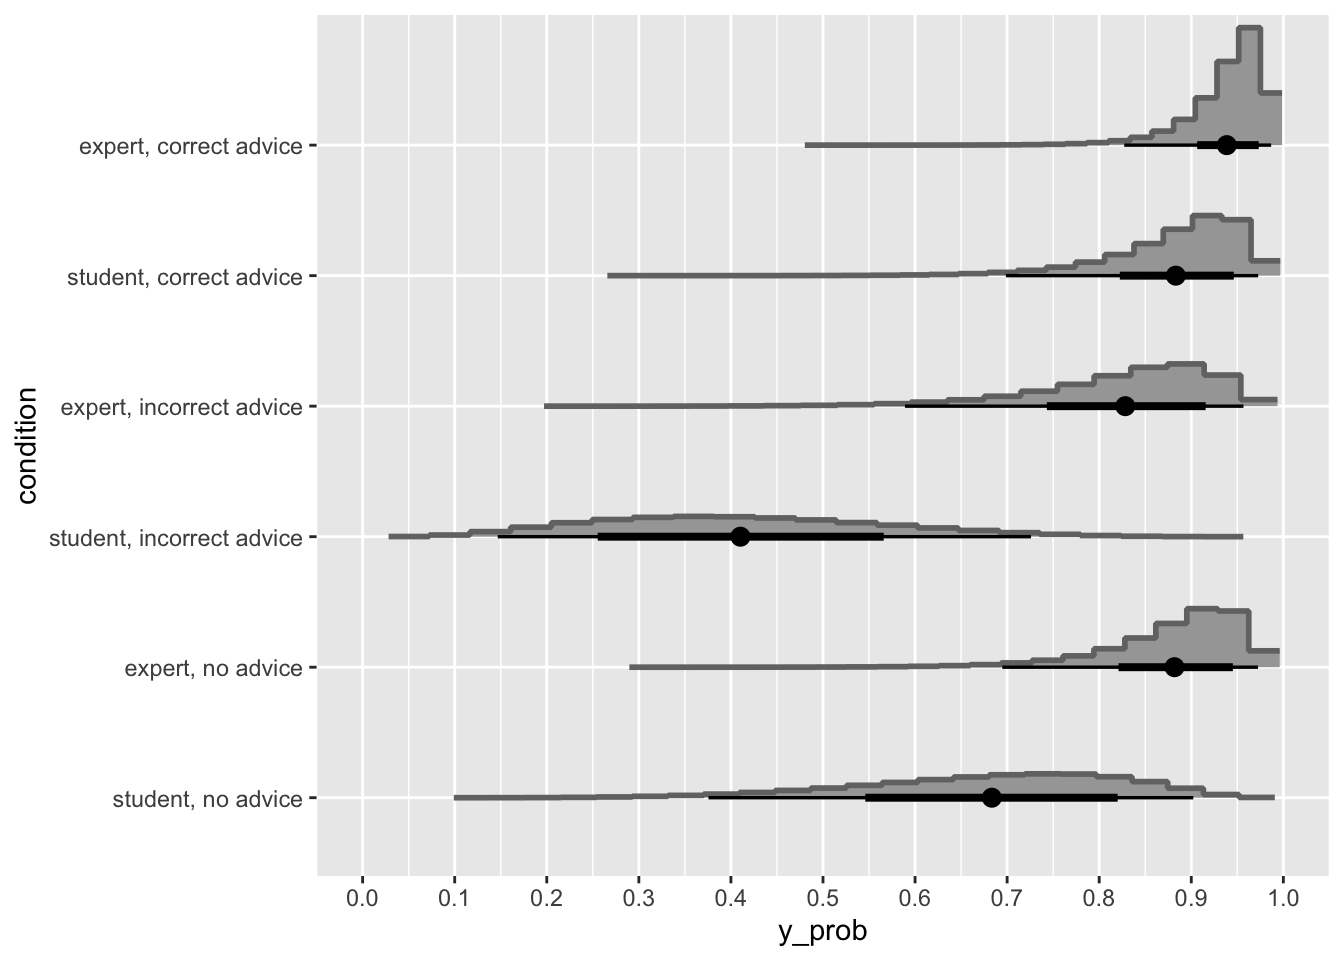

In [ ]:
library(ggdist)
dat |> 
  mutate(condition = fct_cross(
    factor(expert), factor(advice_present), factor(advice_correct))) |>
  mutate(condition = fct_recode(condition,
"student, no advice" = "0:0:0", "expert, no advice" = "1:0:0", 
"student, incorrect advice" = "0:1:0", "expert, incorrect advice" = "1:1:0",
"student, correct advice" = "0:1:1", "expert, correct advice" = "1:1:1")) |> 
  ggplot(aes(x = y_prob, y = condition)) +
  stat_histinterval(point_interval = "mean_qi", slab_color = "gray45",
    breaks = "Sturges") +
  scale_x_continuous(breaks = seq(0, 1, 0.1), limits = c(0, 1))

@fig-margdist1 shows the model-implied marginal distributions, including the mean, 66% and 95% intervals. We can see that, indeed, the average probabilities (black dots) slightly differ from the probabilities of average subjects and items considered previously. This difference increases with the variability of the random effects. We can use plots like @fig-margdist1 as a useful tool to decide whether the specified standard deviations of the subject and item random intercepts ($\sigma_S$ and $\sigma_I$) are reasonable by comparing the ranges and overlap between conditions to domain knowledge.

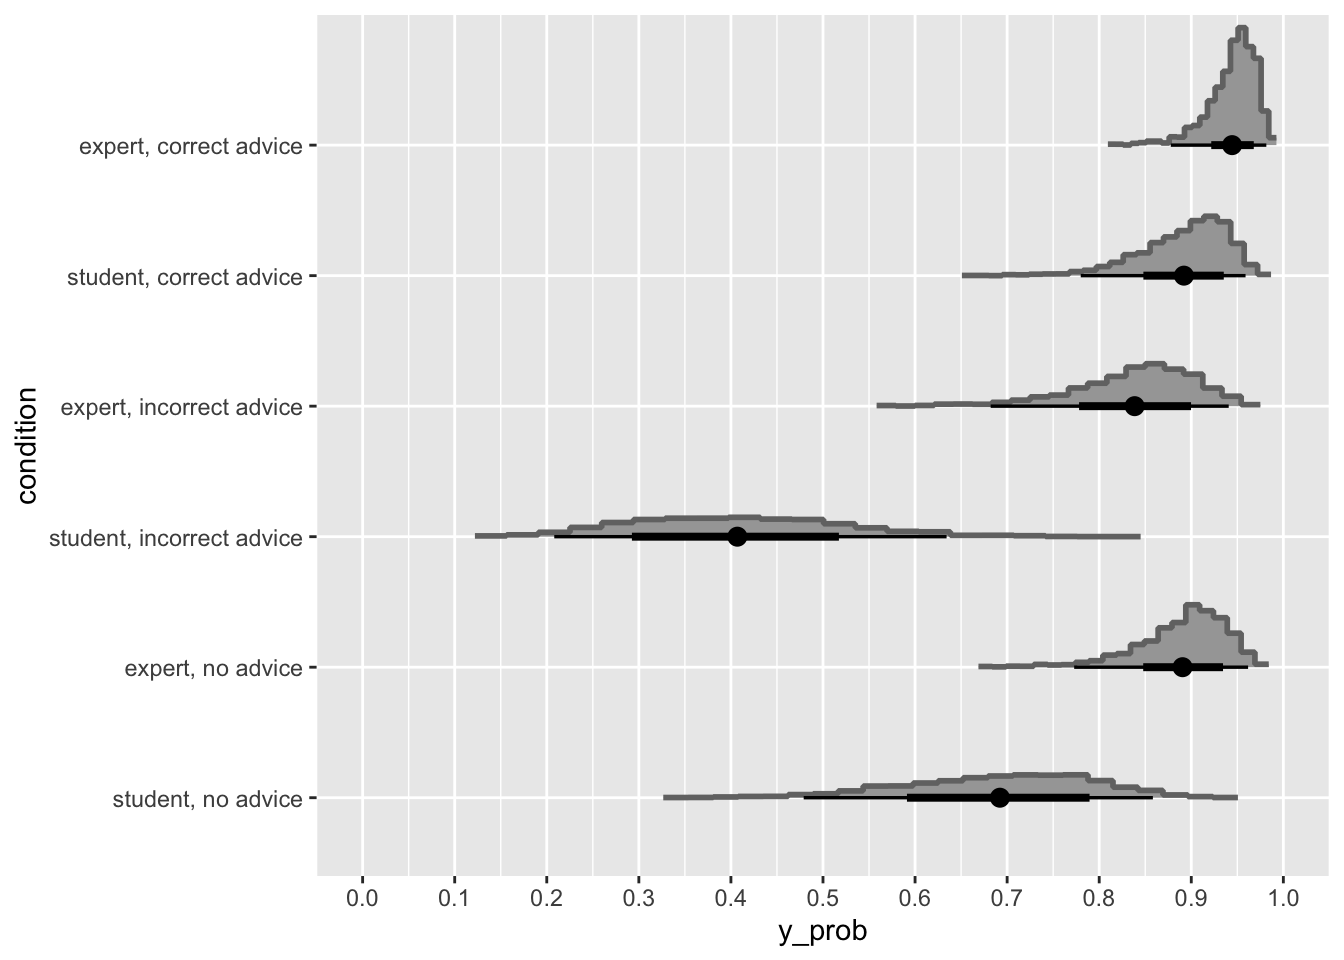

In [ ]:
set.seed(1)
dat <- simulate(n_subjects = 3000, n_items = 3000, sd_u0i = 0.01)
dat |> 
  mutate(condition = fct_cross(
    factor(expert), factor(advice_present), factor(advice_correct))) |>
  mutate(condition = fct_recode(condition,
"student, no advice" = "0:0:0", "expert, no advice" = "1:0:0", 
"student, incorrect advice" = "0:1:0", "expert, incorrect advice" = "1:1:0",
"student, correct advice" = "0:1:1", "expert, correct advice" = "1:1:1")) |> 
  ggplot(aes(x = y_prob, y = condition)) +
  stat_histinterval(point_interval = "mean_qi", slab_color = "gray45",
    breaks = "Sturges") +
  scale_x_continuous(breaks = seq(0, 1, 0.1), limits = c(0, 1))

For the next plot, we have set the item standard deviation to almost zero ($\sigma_I = 0.01$). This gives us a better way to see the variability between persons. As an example, @fig-margdist2 reveals a number of implicit assumptions about the comparison between experts and students: With incorrect advice, virtually all experts have a higher probability of making a correct diagnosis compared to students when considering only items with average difficulty. In contrast, there is considerable overlap in probability between experts and students with no advice and even higher overlap with correct advice. Patterns like these should be considered carefully and discussed with the domain experts. Parameter values ($\beta$ parameters, and $\sigma_S$) should be adjusted if the implications do not seem reasonable. We could also have a closer look at the variability between items by setting the subject standard deviation to almost zero ($\sigma_S = 0.01$).

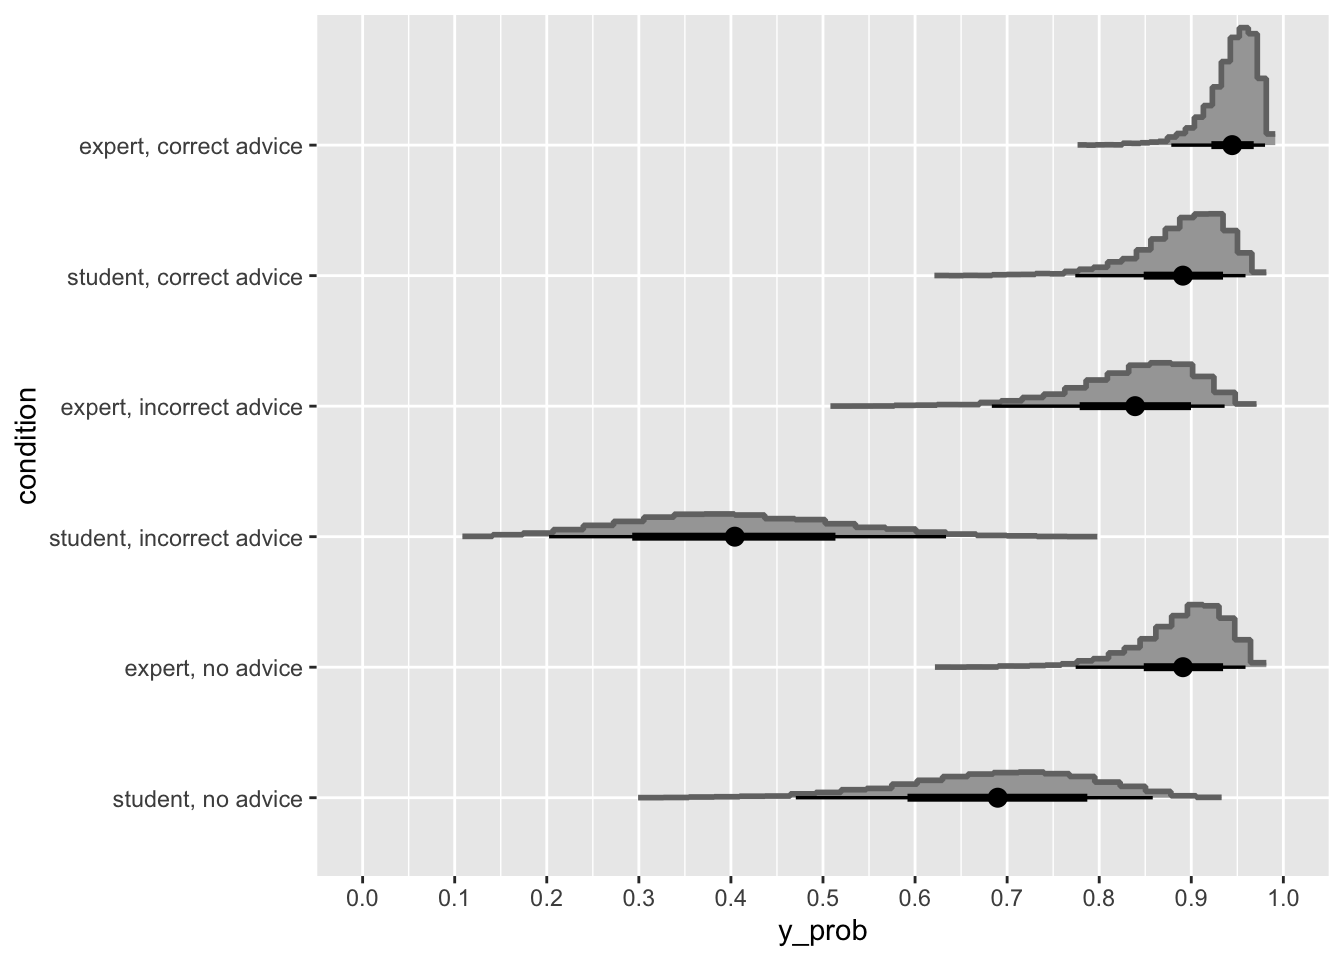

In [ ]:
set.seed(1)
dat <- simulate(n_subjects = 3000, n_items = 3000, sd_u0s = 0.01)
dat |> 
  mutate(condition = fct_cross(
    factor(expert), factor(advice_present), factor(advice_correct))) |>
  mutate(condition = fct_recode(condition,
"student, no advice" = "0:0:0", "expert, no advice" = "1:0:0", 
"student, incorrect advice" = "0:1:0", "expert, incorrect advice" = "1:1:0",
"student, correct advice" = "0:1:1", "expert, correct advice" = "1:1:1")) |> 
  ggplot(aes(x = y_prob, y = condition)) +
  stat_histinterval(point_interval = "mean_qi", slab_color = "gray45",
    breaks = "Sturges") +
  scale_x_continuous(breaks = seq(0, 1, 0.1), limits = c(0, 1))

The final plot demonstrates that these plots are also useful for spotting standard deviations that were specified too high. For @fig-margdist3 we have set $\sigma_S = 3$ and $\sigma_I = 3$. This implies that in each experimental condition, the probabilities that a subject solves an item are overwhelmingly close to either 0 or 1 and nothing in between, which is not a plausible assumption. These high standard deviations do not account for the inherent variability and complexity of human performance. For example, the expectation that an expert with low ability and incorrect advice would solve a difficult item with a probability close to zero is not convincing.

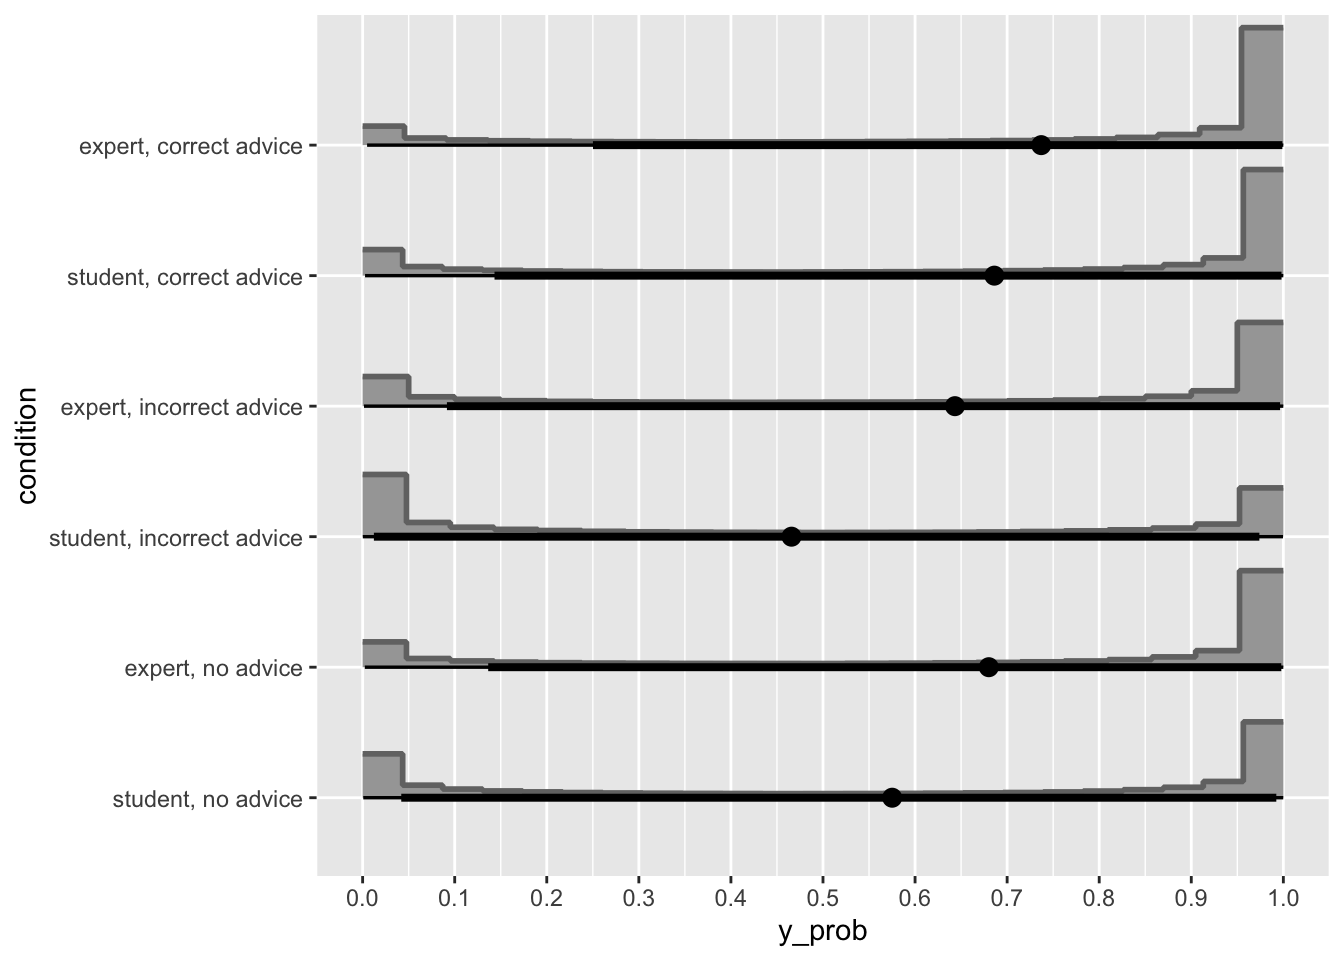

In [ ]:
set.seed(1)
dat <- simulate(n_subjects = 3000, n_items = 3000, sd_u0s = 3, sd_u0i = 3)
dat |> 
  mutate(condition = fct_cross(
    factor(expert), factor(advice_present), factor(advice_correct))) |>
  mutate(condition = fct_recode(condition,
    "student, no advice" = "0:0:0", "expert, no advice" = "1:0:0", 
    "student, incorrect advice" = "0:1:0", "expert, incorrect advice" = "1:1:0",
    "student, correct advice" = "0:1:1", "expert, correct advice" = "1:1:1")) |> 
  ggplot(aes(x = y_prob, y = condition)) +
  stat_histinterval(point_interval = "mean_qi", slab_color = "gray45",
    breaks = "Sturges") +
  scale_x_continuous(breaks = seq(0, 1, 0.1), limits = c(0, 1))

### Iterate with domain experts

#### THEORY

Gathering domain knowledge and the specification of population parameter values is an iterative process, in which domain experts repeatedly assess the plausibility of simulated data. As a first step, domain experts can be interviewed to “elicit” their domain knowledge about how the data of the planned study is expected to look. As most domain experts are no experts in statistical modeling and GLMMs, they often struggle without further guidance to communicate their knowledge in a way that is useful when specifying the parameters for data simulation. For this reason, we suggest that after an initial interview, the analyst who is familiar with the structure of the GLMM selects an initial set of insightful descriptive statistics and model-based quantities. Then they reenter into an iterative discussion with the domain experts where some set of population values are selected, and the plausibility of resulting implied quantities is evaluated. Then, the population parameters are updated until the domain experts are satisfied with the result. During this process, the monitored descriptive statistics and model-based quantities can be updated or extended to capture as much available domain knowledge as possible.

##### PRACTICE

All parameter values in our present case study have been determined based on repeated discussions with domain experts in radiology to validate our assumptions. Initially, we reviewed the literature to establish a reasonable baseline performance rate for examining head CT scans for intracranial hemorrhage. Existing studies indicate that radiologists typically demonstrate high accuracies around 90%, while interns have been shown to perform below 80%, and medical students fall even shorter. For simplicity, we assumed plausible probability values of .90 for experts and .70 for students, respectively. Our experts confirmed that these values are realistic baselines for reviewing diverse head CT images without AI assistance. Subsequently, we consulted several published papers investigating the effect of correct and incorrect advice on decision-making performance in other settings. From their findings, we inferred that both experts and students should benefit from correct and suffer losses from incorrect advice. However, the magnitude of these effects should be substantially greater for students, given their stronger reliance on advice compared to experts. We further validated the plausibility of our estimated gains and losses with the collaborating radiologists until we settled on the probabilities shown in @tbl-probtable.

## Step 4: Estimate the statistical model

### THEORY

At this point, the researcher is capable of producing a simulated dataset that is comparable to the actual dataset to be collected in the planned study. The next step is to specify how the statistical model shall be estimated in the actual study collected later. This requires the selection of a statistical framework, a software package that is capable of estimating the model class of interest, an estimation algorithm, and the specific model structure including all fixed effects, random effects, and the model family of the dependent variable.

Note that this does not always mean that one will specify the same GLMM that was used when specifying the data-generating process. On the one hand, using a simpler model for data simulation than for model estimation can be a useful strategy in scenarios where making plausible assumptions for complicated random effect structures and interactions is not feasible. On the other hand, using a more complex model for data simulation than for model estimation can be a useful strategy in scenarios where one has specific domain knowledge about aspects of the data-generating process that are still difficult to estimate with the current state-of-the-art in multilevel modeling.

### PRACTICE

In our case study, we use the *lme4* R package \[@batesFittingLinearMixedEffects2015\], which is a state-of-the-art tool for fitting frequentist GLMMs.[1] For the current example, we simulate data according to our model, in which 100 subjects respond to 50 items (we use `set.seed` to make the simulation reproducible). However, for the sake of the exercise, we can imagine that this would be real data resulting from our future experiment and think about how we would analyze this data.

[1] For Bayesian GLMMs, the *brms* R package is currently the most prominent option \[@burknerBrmsPackageBayesian2017\].

In [ ]:
library(tidyverse)
set.seed(1)
dat <- simulate(n_subjects = 100, n_items = 50)

The *lme4* package uses a special syntax for model specification. Our specific GLMM is represented by the formula:

In [ ]:
library(lme4)
f <- y_bin ~ 1 + expert + advice_present + advice_correct + 
  expert:advice_present + expert:advice_correct +
  (1|subject) + (1|item)

The first two lines look similar to any linear model in R (general intercept indicated by `1`; main effects indicated by variable names in the dataset; interactions indicated by `variable1:variable2`). The third line specifies a random intercept for each subject `(1|subject)` and for each item `(1|item)`. The complete set of rules for the syntax is outlined in @batesFittingLinearMixedEffects2015 and in the documentation of the *lme4* package.

In *lme4*, a GLMM is fitted with the `glmer` function. By setting `family =  "binomial"`, we request a binomial GLMM appropriate for our binary dependent variable `y_bin` (the binomial GLMM uses the canonical logit link by default), which is defined as an accurate (1) vs. inaccurate (0) diagnosis. We use the default estimation algorithm (see `?glmerControl` for a list of alternative options).

In [ ]:
fit <- glmer(f, data = dat, family = "binomial")

We can inspect the estimates for all model parameters with the `summary` command:

In [ ]:
summary(fit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
y_bin ~ 1 + expert + advice_present + advice_correct + expert:advice_present +  
    expert:advice_correct + (1 | subject) + (1 | item)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
  4149.4   4201.6  -2066.7   4133.4     4992 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7669  0.2125  0.3046  0.4317  2.1056 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.3148   0.5611  
 item    (Intercept) 0.1624   0.4029  
Number of obs: 5000, groups:  subject, 100; item, 50

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.0339     0.1103   9.374  < 2e-16 ***
expert                  1.1849     0.2096   5.654 1.56e-08 ***
advice_present         -1.3436     0.1206 -11.143  < 2e-16 ***
advice_correct          2.6154     0.1273  20.540  < 2e-16 ***
exper

In the model output, the `Estimate` column in the `Fixed effects` table contains the estimates for the $\beta$ parameters, while the `Std.Dev.` column in the `Random effects` table contains the estimates for $\sigma_S$ and $\sigma_I$.

## Step 5: Compute the estimate

### THEORY

In previous steps, we have defined the theoretical estimand, written a data simulation function and specified how to estimate a GLMM using simulated data. The next step is to specify how to compute a concrete point estimate of the theoretical estimand within the framework of the fitted GLMM. For some research questions, the estimate corresponds with a single regression coefficient. In more complicated scenarios, the estimate is computed from a combination of coefficients. Beyond computing the point estimate, we have already discussed that both hypothesis testing and interval estimation could be used to answer the research question. The decision on testing or estimating is then followed by selecting the specific statistical method that shall be applied to compute the HTs or CIs (e.g., compute HTs and CIs with the *marginaleffects* R package using the delta method).

### PRACTICE

In the estimand section, we have translated a verbal description of our research question into four probability statements that are specified outside of any specific statistical model. For a concrete estimate within the context of our specified GLMM, we must compute the following probability contrasts:

$$
\begin{aligned}
& P(Y=1|advice\_present = 1, advice\_correct = 1, expert = 1, u_{0s} = 0, u_{0i} = 0) \\
& \quad - P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 1, u_{0s} = 0, u_{0i} = 0)
\end{aligned}
$$ $$
\begin{aligned}
& P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 1, u_{0s} = 0, u_{0i} = 0) \\
& \quad - P(Y=1|advice\_present = 1, advice\_correct = 0, expert = 1, u_{0s} = 0, u_{0i} = 0)
\end{aligned}
$$

$$
\begin{aligned}
& P(Y=1|advice\_present = 1, advice\_correct = 1, expert = 0, u_{0s} = 0, u_{0i} = 0) \\
& \quad - P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0)
\end{aligned}
$$

$$
\begin{aligned}
& P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0) \\
& \quad - P(Y=1|advice\_present = 1, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0)
\end{aligned}
$$ We have already discussed how to compute the involved probabilities in the section on specifying population parameters. Plugging in the GLMM model equation produces an equation for computing each contrast if all model parameters were known. When we want to estimate the above contrasts based on observed data, the only difference is that model parameters are not known and we instead use the corresponding parameter estimates.

We could use our knowledge of the structure of the GLMM to determine the exact formula needed to compute the contrasts of interest and then plug in the parameter estimates manually from the `summary(fit)` output. However, this would be tedious and we can use R to compute this contrast without doing the math. Using the first contrast *(correct advice, expert) - (no advice, expert)* as our example, we could apply the `predict` function of the *lme4* package to compute the predicted probability for a correct diagnosis based on our fitted model, plug in the two sets of predictor values, and compute the difference between the two estimated probabilities.

In [ ]:
grid1 <- data.frame(advice_present = c(1, 0), advice_correct = c(1, 0), 
  expert = c(1, 1))
grid1

  advice_present advice_correct expert
1              1              1      1
2              0              0      1

       1        2 
0.939292 0.901923 

         1 
0.03736901 

The argument `type = "response"` specifies that predictions are made on the probability scale (instead of the log-odds scale of the $\beta$ parameters), while `re.form = NA` sets all random effects to 0. We could use this method to compute point estimates for all four contrasts that are part of our estimand. However, depending on whether we are interested in hypothesis testing or parameter estimation, we also need a method to compute HTs or CIs. The *marginaleffects* package \[@R-marginaleffects\] is a very flexible, increasingly popular package to compute HTs and CIs for contrasts with a variety of statistical models, including GLMMs estimated with *lme4*. First, we specify a grid of all combinations of predictor variables and then compute estimated probabilities for all experimental conditions in our experiment with the `predictions` function:

In [ ]:
library(tidyverse)
library(marginaleffects)
library(tinytable)
grid2 <- expand_grid(advice_present = 0:1, 
  advice_correct = 0:1, expert = 0:1)
grid2

# A tibble: 8 × 3
  advice_present advice_correct expert
           <int>          <int>  <int>
1              0              0      0
2              0              0      1
3              0              1      0
4              0              1      1
5              1              0      0
6              1              0      1
7              1              1      0
8              1              1      1

<!DOCTYPE html> 
 
 
 
 
 tinytable_wctp02o7pc0nmd03q7fo 
 
 
 
 
 

 
 
 
 
 
 
 Estimate 
 Std. Error 
 z 
 Pr(>|z|) 
 S 
 2.5 % 
 97.5 % 
 advice_present 
 advice_correct 
 expert 
 
 
 Type: response 
 
 Columns: rowid, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high, advice_present, advice_correct, expert, y_bin 
 
 
 
 0.738 
 0.02134 
 34.6 
 <0.001 
 867.2 
 0.696 
 0.779 
 0 
 0 
 0 
 
 
 0.902 
 0.01739 
 51.9 
 <0.001 
 Inf 
 0.868 
 0.936 
 0 
 0 
 1 
 
 
 0.975 
 0.00421 
 231.6 
 <0.001 
 Inf 
 0.966 
 0.983 
 0 
 1 
 0 
 
 
 0.954 
 0.01454 
 65.6 
 <0.001 
 Inf 
 0.925 
 0.982 
 0 
 1 
 1 
 
 
 0.423 
 0.03221 
 13.1 
 <0.001 
 128.6 
 0.360 
 0.486 
 1 
 0 
 0 
 
 
 0.874 
 0.02793 
 31.3 
 <0.001 
 711.4 
 0.819 
 0.928 
 1 
 0 
 1 
 
 
 0.909 
 0.00967 
 94.1 
 <0.001 
 Inf 
 0.890 
 0.928 
 1 
 1 
 0 
 
 
 0.939 
 0.01091 
 86.1 
 <0.001 
 Inf 
 0.918 
 0.961 
 1 
 1 
 1

The point estimates for all experimental conditions are reported in the `Estimate` column. Note that the output also contains the two missing by design conditions that will never be observed in the actual study ($advice\_present = 0, advice\_correct = 1, expert = 1$ and $advice\_present = 0, advice\_correct = 1, expert = 0$). This is no problem as long as we never interpret those estimates. Next, we use the estimated probabilities to compute the four specific contrasts that are part of our estimand. For this, we must specify which rows in `preds` have to be subtracted from each other. We will use the `hypotheses` function to compute our four contrasts of interest together with HTs and CIs. We use the default inference options of the *marginaleffects* package that compute HTs and CIs based on the approximate delta method.

In [ ]:
contrasts <- preds |> 
  hypotheses(hypothesis = c(
    "b8 = b2",  # (correct advice, expert) - (no advice, expert)
    "b2 = b6",  # (no advice, expert) - (incorrect advice, expert) 
    "b7 = b1",  # (correct advice, student) - (no advice, student)
    "b1 = b5"), # (no advice, student) - (incorrect advice, student)
    equivalence = c(0, 0))
print(contrasts, style = "tinytable") |> theme_tt(theme = "resize")

<!DOCTYPE html> 
 
 
 
 
 tinytable_ns4lfqa07u3am44tgx8z 
 
 
 
 
 

 
 
 
 
 
 
 Term 
 Estimate 
 Std. Error 
 z 
 Pr(>|z|) 
 S 
 2.5 % 
 97.5 % 
 p (NonSup) 
 p (NonInf) 
 p (Equiv) 
 
 
 Type: response 
 
 Columns: term, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high, statistic.noninf, statistic.nonsup, p.value.noninf, p.value.nonsup, p.value.equiv 
 
 
 
 b8=b2 
 0.0374 
 0.0162 
 2.31 
 0.021 
 5.6 
 0.00563 
 0.0691 
 0.989 
 0.0105 
 0.989 
 
 
 b2=b6 
 0.0282 
 0.0279 
 1.01 
 0.312 
 1.7 
 -0.02653 
 0.0830 
 0.844 
 0.1562 
 0.844 
 
 
 b7=b1 
 0.1717 
 0.0173 
 9.93 
 <0.001 
 74.8 
 0.13780 
 0.2056 
 1.000 
 <0.001 
 1.000 
 
 
 b1=b5 
 0.3145 
 0.0280 
 11.24 
 <0.001 
 95.0 
 0.25965 
 0.3693 
 1.000 
 <0.001 
 1.000

The expression `"b8 = b2"` is special syntax to subtract the estimate in row number 8 from the estimate in row number 2 in the `preds`-output. The argument `equivalence = c(0, 0)` can be used to compute one-sided p-values, testing whether the contrast in the population is smaller than 0 (`p (NonSub)` column) or greater than 0 (`p (NonInf)` column). The point estimates for four contrasts are reported in the `Estimate` column. Note that to facilitate interpretation, we arranged the contrasts in a way that we theoretically expect positive values for all four of them.

#### Hypothesis testing

If we chose hypothesis testing for our case study, we would test a combined null hypothesis $H_0$ that consists of four separate null hypotheses: $$
\begin{aligned}
H_{01}:\ & P(Y=1|advice\_present = 1, advice\_correct = 1, expert = 1, u_{0s} = 0, u_{0i} = 0) \leq \\
& P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 1, u_{0s} = 0, u_{0i} = 0) \\
H_{02}:\ &P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 1, u_{0s} = 0, u_{0i} = 0) \leq \\
& P(Y=1|advice\_present = 1, advice\_correct = 0, expert = 1, u_{0s} = 0, u_{0i} = 0) \\
H_{03}:\ &P(Y=1|advice\_present = 1, advice\_correct = 1, expert = 0, u_{0s} = 0, u_{0i} = 0) \leq \\
& P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0) \\
H_{04}:\ & P(Y=1|advice\_present = 0, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0) \leq \\
& P(Y=1|advice\_present = 1, advice\_correct = 0, expert = 0, u_{0s} = 0, u_{0i} = 0)
\end{aligned}
$$ The combined null hypothesis $H_0$ should only be rejected if **all** individual null hypotheses are rejected \[i.e., intersection-union setting\\ @dmitrienkoTraditionalMultiplicityAdjustment2013\]. In such cases, the error probabilities do not accumulate, and we would waste power when correcting for multiple tests.

With a standard significance level of $\alpha = 0.05$, we would not reject all four null hypotheses (the p-value in the `p (NonInf)` column for the second hypothesis is not significant) and therefore also not reject the combined null hypothesis for this particular (simulated) dataset. Note that this decision would be wrong because we have simulated the data such that the combined alternative hypothesis $H_1$ is actually true in the population.

#### Interval estimation

If we chose parameter estimation for our case study, we would focus on the two-sided CIs of the four contrasts of interest. With a standard confidence level of $1 - \alpha = 0.95$ plausible values are clearly in the positive range for the first, third, and fourth contrast, while both negative and positive values seem plausible for the second contrast. Note that due to the constrained range of the probability scale, the width of the CI differs between the four contrasts (which is the expected behavior for binomial GLMMs). The smallest width is observed for the first contrast (expert with correct advice vs. expert without advice), where both underlying probabilities are close to 1. The largest width is observed for the fourth contrast (student with incorrect advice vs. student without advice), where both underlying probabilities are closer to 0.5.

## Step 6: Perform repeated simulations

### THEORY

Conducting all previous steps enables the analyst to 1) simulate a dataset, 2) estimate a GLMM, and 3) compute HTs or CIs for estimands of interest, mirroring the analysis that will later be conducted on the actual dataset of the planned study. To produce an estimate of power or precision, the last step is to perform these previous steps repeatedly. On a conceptual level, we first require a function that takes a sample size and a full set of population parameter values as input. When planning for power, the function should return the p-value(s) of the HT(s) of interest when conducted on the simulated dataset. When planning for precision, the function should return the width of the CI(s) of interest. Second, we run this function repeatedly with the same sample size and population parameters. Because fitting GLMMs can quickly become time-consuming, it is recommended to use parallel computing, that is running simulations on multiple cores of the computer at the same time to reduce total run time. Third, the results of the repeated simulation are collected and aggregated. When planning for power, we compute the relative frequency of (a) significant p-value(s) across repeated simulations. When planning for precision, we compute the average width of the CI(s). Finally, we repeat the complete simulation for different sample sizes to determine how big the sample must be in order to achieve the targeted power or precision.

### PRACTICE

Wrapping the `simulate` function already constructed earlier, the helper function `sim_and_analyse` performs all previous steps (simulate a dataset, fit a GLMM, compute p-values and CIs) in a single command.

In [ ]:
sim_and_analyse <- function(
  formula_chr = "y_bin ~ 1 + expert + advice_present + advice_correct + 
    expert:advice_present + expert:advice_correct + (1|subject) + (1|item)",
  contrasts = c("b8 = b2", "b2 = b6", "b7 = b1", "b1 = b5"), ...){
  require(lme4)
  require(marginaleffects)
  require(tidyr)
  # simulate data
  dat <- simulate(...)
  # fit model
  model <- glmer(as.formula(formula_chr), data = dat, family = "binomial")
  # compute contrasts
  contr_df <- expand_grid(advice_present = 0:1, advice_correct = 0:1,
    expert = 0:1)
  predictions(model, newdata = contr_df, type = "response", re.form = NA) |>
    hypotheses(hypothesis = contrasts, equivalence = c(0, 0)) |>
    data.frame()
}

We use the *future* \[@R-RJ-2021-048\] and *furrr* \[@R-furrr\] packages to perform computations in parallel. First, we enable parallelization with the `plan` function and specify how many parallel cores (“workers”) of our computer to use (users can find out the maximum number of cores on their computer with the command `parallel::detectCores()`), and set a seed to make the simulation reproducible.

In [ ]:
library(future)
plan("multisession", workers = 6)
set.seed(2)

The next code chunk specifies a simulation grid with different settings for both the number of subjects (`n_subjects`) and the number of items (`n_items`), each combination being repeated `rep` times. The more repetitions, the more accurately power and precision can be estimated. We chose 300 repetitions for the data simulation at hand to strike a balance between achieving a robust estimate and remaining computationally feasible. With the current settings, this simulation takes about one hour on a MacBook Pro from 2020 with M1 chip and 16 GB working memory. If you want to quickly experiment with the code yourself, a setting with `workers = 4` and `rep = 5` should finish in less than 5 minutes, even on smaller machines.

In [ ]:
library(furrr)
sim_result <- crossing(
  rep = 1:300,
  n_subjects = c(100, 150, 200, 250),
  n_items = c(10, 30, 50, 70)
) |>
  mutate(res = future_pmap(., sim_and_analyse, 
    .options = furrr_options(seed = TRUE))) |>
  unnest(col = res)

The result of this computation is a data frame that contains the p-values and CIs of all specified contrasts for each simulated dataset. In some iterations (predominantly in conditions with small sample sizes), model estimation did not converge with the *lme4* package. When the model fails to converge, it means that the statistical model being fitted to the data failed to reach a stable or valid solution during the estimation process. We do not remove these results because non-convergence can also happen when analyzing the real data we plan to collect, thus, we want to factor in this possibility to keep our simulation more realistic.

#### Power results

For our exemplary combined hypothesis, power is defined as the (long-run) percentage of simulations in which all four p-values of our individual hypotheses are significant at the $\alpha = 0.05$ level. Based on our simulation outcomes, we compute a power estimate for each combination of `n_subjects` $\times$ `n_items` (including 95% CIs) and visualize the results with the following code.[1]

[1] This code was inspired by the “Mixed Design Simulation” vignette of the *faux* package at <https://debruine.github.io/faux/articles/sim_mixed.html>.

In [ ]:
# The simulation results were computed in the full_simulation.qmd notebook
sim_result <- readRDS(file = "results.rds")

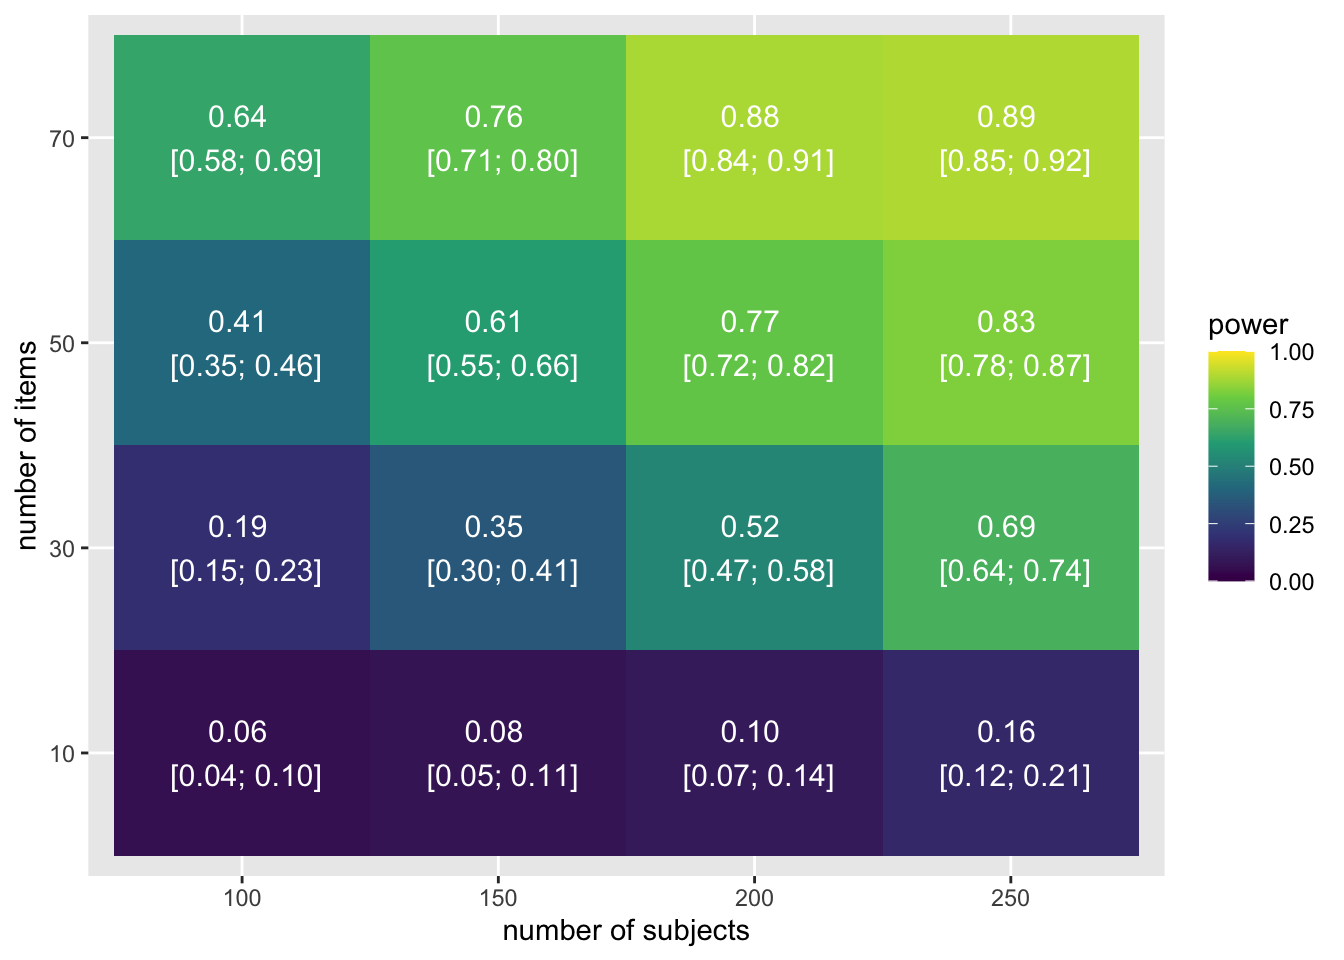

In [ ]:
library(binom)
alpha <- 0.05
power <- sim_result |>
  pivot_wider(names_from = term, names_sep = "_", 
    values_from = estimate:p.value.equiv) |>
  group_by(n_subjects, n_items) |> 
  summarise(
    power = mean(`p.value.noninf_b1=b5` < alpha & 
        `p.value.noninf_b8=b2` < alpha & `p.value.noninf_b2=b6` < alpha & 
        `p.value.noninf_b7=b1` < alpha), 
    n_sig = sum(`p.value.noninf_b1=b5` < alpha & 
        `p.value.noninf_b8=b2` < alpha & `p.value.noninf_b2=b6` < alpha & 
        `p.value.noninf_b7=b1` < alpha),
    n = n(),
    ci.lwr = binom.confint(n_sig, n, method = "wilson")$lower,
    ci.upr = binom.confint(n_sig, n, method = "wilson")$upper, 
    .groups = "drop")
power |>
  mutate(across(c(n_subjects, n_items), factor)) |>
  ggplot(aes(n_subjects, n_items, fill = power)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f \n [%.2f; %.2f]", 
                                power, ci.lwr, ci.upr)), 
    color = "white", size = 4) +
  scale_fill_viridis_c(limits = c(0, 1)) +
  xlab("number of subjects") + ylab("number of items")

As should be the case, power estimates in @fig-finalpwr increase with both the number of subjects and the number of items. The CIs reported here indicate how precisely power was estimated by our simulation. Higher precision (which would be reflected in narrower CIs) could be obtained by increasing the number of repetitions (`rep`) in the simulation. In practice, data simulations are often run multiple times with adjusted combinations of sample sizes. When running for the first time, it might be revealed that power is way too low (or much higher than required) for some combinations of `n_subjects` and `n_items`. When narrowing down the best combination that achieves sufficient power while at the same time striking a good balance of how many subjects and items are practically feasible, later rounds of data simulation will typically include a smaller grid of sample sizes combined with a higher number of repetitions. This will assure high precision for the final power estimates, which are then used for the sample size justification of the planned study.

When target power has been specified, the number of subjects and the number of items in our study design can be traded against each other based on practical considerations. Although it is recommended to justify the power \[@lakensSampleSizeJustification2022\], we adopt the common heuristic to target a power of 0.8 to detect an effect of the expected size implied by our data simulation. This could be achieved by collecting data from 200 subjects (about 25% of which will be experts), each completing the same 50 items (with advice present in about 67% of cases, which is correct in about 80% of cases with present advice). If collecting data from 200 subjects is not feasible, an alternative would be to recruit 150 subjects but increase the length of the experiment to over 70 items. However, 70 items might take too long to complete for the radiologists participating in the study, who have a busy schedule. The simulation suggests that it might also be possible to plan a shorter experiment with only 30 items if it is feasible to recruit an even higher number of subjects (\> 250, to be determined by additional rounds of power analysis). Design parameters that also affect power, and which could be investigated in the simulation to find a more optimal trade-off, are the ratio of experts to students, the frequency of whether advice is presented at all, and whether it is correct or incorrect.

#### Precision results

When planning for precision, one could monitor the width of all four CIs at the same time. However, because the CIs of the four contrasts strongly differ in width, it is not trivial to decide which width one should target when deciding on the appropriate sample size. In contrast to planning for power, there are no common standards on how to specify the targeted precision \[@lakensSampleSizeJustification2022\]. For our example, we use a simple heuristic but we strongly encourage readers to think about better alternatives that are appropriate in their own applications. Our simulations show that the smallest CI can be expected for the first contrast (expert with correct advice vs. expert without advice). The true contrast in probability for an average expert and an average item in this condition is `plogis(b_0 + b_e + b_a + b_c + b_ea + b_ec) - plogis(b_0 + b_e) =` $0.05$. We want the width of this CI to be smaller than 0.1. This would mean that if the point estimate happens to be close to the true value, the plausible values inside of a 95% CI would all be positive.

Thus in our example, precision is defined as the (long-run) average width of a 95% CI for the probability contrast between experts with correct advice and experts without advice. Of course, a lower width implies better precision. Based on our simulation outcomes, we compute the precision estimate for each combination of `n_subjects` $\times$ `n_items` (including 95% CIs) and visualize the results with the following code.

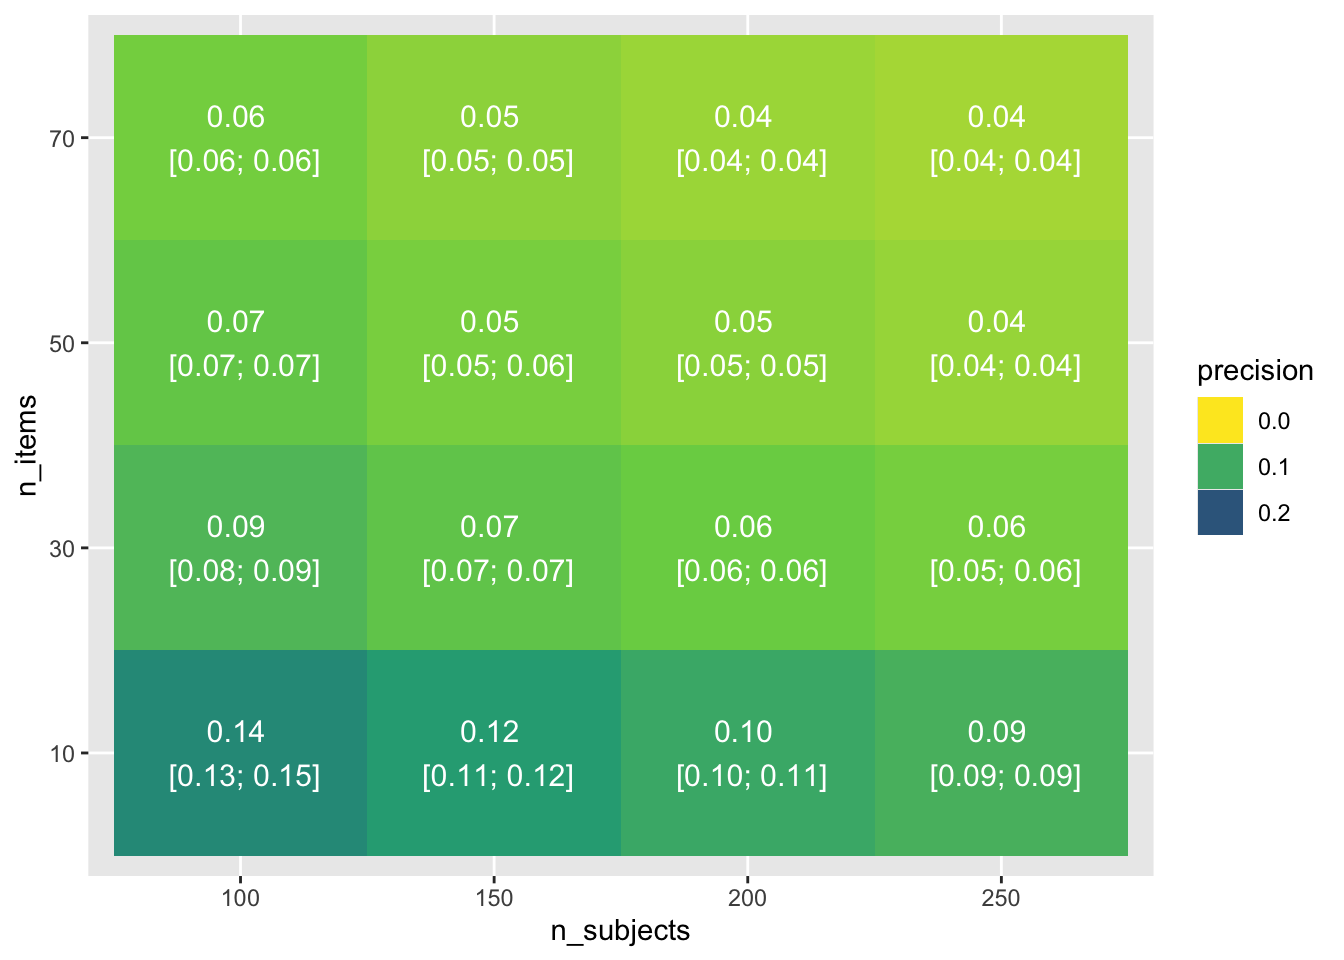

In [ ]:
precision <- sim_result |>
  pivot_wider(names_from = term, names_sep = "_", 
    values_from = estimate:p.value.equiv) |>
  group_by(n_subjects, n_items) |>
  mutate(width = `conf.high_b8=b2` - `conf.low_b8=b2`) |>
  summarise(precision = mean(width),
    ci.lwr = t.test(width)$conf.int[1],
    ci.upr = t.test(width)$conf.int[2], 
    .groups = "drop")
precision |>
  mutate(across(c(n_subjects, n_items), factor)) |>
  ggplot(aes(n_subjects, n_items, fill = precision)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f \n [%.2f; %.2f]", 
                                precision, ci.lwr, ci.upr)), 
    color = "white", size = 4) +
  scale_fill_viridis_c(limits = c(0, 0.3), direction = -1) +
  guides(fill = guide_legend(reverse=FALSE))

As should be the case, precision estimates in @fig-finalprecision increase (i.e., average width of CI decreases) with the number of included subjects and items. The CIs reported here indicate how precisely the expected width of the CI for our focal contrast was estimated by our simulation. Applying our simple heuristic of targeting an expected CI width that is smaller than 0.1, we see the same trade-off between the number of subjects and the number of items as with planning for power. We could either choose 100 subjects and 30 items or 200 subjects and 10 items. Note that our simple heuristic for determining sample size in the planning for precision scenario was quite liberal. This is reflected in the result that we would need a smaller sample size than in the planning for power scenario. With a more conservative precision target, the result is generally the opposite: As a rule, precise parameter estimates usually require bigger samples than null hypothesis testing.

## Step 7 (optional): Sensitivity analysis

In our case study, we have performed simulation-based sample size planning from a single set of parameter values that reflect our assumptions of an expected effect size. Instead of extracting this expected effect size from meta-analyses or pilot data, which has been the main focus of previous tutorials \[e.g., @kumleEstimatingPowerGeneralized2021\], we have demonstrated some strategies to determine plausible parameter values in GLMMs based on domain knowledge. When sample sizes are chosen based on the results of our simulation-based power analysis, a future study will be informative to reject the null hypothesis if an effect of our *expected size* is present (or estimate the effect with satisfying precision). However, if the true effect is indeed smaller, power (or precision) will be lower, and the study might not be sufficiently informative. A common, more conservative strategy for sample size justification is to perform sample size planning for the smallest effect size of interest (SESOI). An effect smaller than the SESOI would be considered too small to be interesting or practically meaningful, even if the effect is not actually zero \[@kingPointMinimalImportant2011; @lakensEquivalenceTestingPsychological2018\]. Unfortunately, specifying a plausible SESOI is a challenging task (for strategies on how to specify a SESOI, see @lakensSampleSizeJustification2022, @riesthuisSimulationBasedPowerAnalyses2024, or @lakensImprovingYourStatistical2022). When domain knowledge or formal theories about the research topic of interest are too vague to specify a meaningful SESOI, it is still recommended to demonstrate power or precision for different effect sizes in a *sensitivity power analysis* \[@lakensSampleSizeJustification2022\]. By simulating power (or precision) for different effect sizes (in addition to the different number of subjects and items), one can make sure that power (or precision) would still be sufficient to detect smaller effect sizes than our expected effect or at least get an impression of how strongly power (or precision) depends on the size of the true effect. For our case study that investigates combined hypotheses in a GLMM modeling framework, sensitivity analysis would require manually specifying additional sets of plausible parameter values that reflect scenarios with smaller or larger differences between groups with respect to our specific research question. Power (or precision) could then be simulated for several of these scenarios (across different numbers of subjects and items, as considered earlier). Although recommended, we do not present a sensitivity analysis for our case study to keep the length of the tutorial manageable.

# Conclusion and outlook

In this tutorial, we provided a step-by-step guide on how to perform tailored simulation-based sample size planning for GLMMs based on a concrete case study. To conclude, we want to give an outlook on five developments regarding the future role of simulation-based sample size planning in experimental research:

1.  As experimental designs become more complex and the appropriate flexible statistical frameworks, like GLMMs, become more popular, there is an ever growing need for simulation-based sample size planning in experimental research.

2.  The ability to conduct simulation-based sample size planning becomes an increasingly valuable skill that should be taught to experimental researchers. By incorporating such training into research methods courses and workshops, researchers can improve the quality of their experimental designs and enhance the rigor of their studies. The need to reason about how to simulate plausible data that is in line with the research hypothesis, while not violating domain expertise on how plausible data should look might also contribute to planning more insightful studies that can answer more precise research questions \[@yarkoniGeneralizabilityCrisis2022\].

3.  Given the significant disconnect between the amount of effort required to perform tailored simulation-based sample size planning and the perceived effort estimated by researchers and collaborators in experimental research, there is a need to address the mismatch in effort perception. Many researchers request simulation-based power analyses from statisticians or methodological experts without fully comprehending the complexity and time-consuming nature of these tailored simulations. Therefore, it is crucial to raise awareness about the effort involved to ensure realistic expectations and effective collaboration with methodological experts.

4.  Tailored data simulations and power analyses are not mere technicalities; they are valuable research contributions that deserve adequate recognition in experimental research. Their importance can be reflected by highlighting the simulation work in a publication or even allocating them a separate publication, or incorporating them as a significant component of stage 1 preregistered reports \[@chambersPresentFutureRegistered2022\].

5.  Simulation-based sample size planning aligns well with the principles of Open Science and preregistration and could be further integrated. When researchers have access to simulated data based on their pre-specified model, analyzing the collected dataset becomes straightforward and unambiguous. By preregistering their simulation-based sample size plan, researchers enhance the transparency and accountability of their experimental procedures, contributing to the credibility and reproducibility of research.

# References